# Práctica 1. Aprendizaje Automático

Authors: Carlos Iborra Llopis (100451170), Alejandra Galán Arrospide (100451273)


# 0. Table of contents

- [Práctica 1. Aprendizaje Automático](#práctica-1-aprendizaje-automático)
  - [0. Table of contents](#0-table-of-contents)
  - [1. Requirements](#1-requirements)
  - [2. Reading the datasets](#2-reading-the-datasets)
  - [3. Exploratory Data Analysis](#3-EDA)

# 1. Requirements


In [37]:
""" Importing necessary libraries """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import scipy.stats as st
import scipy
import sklearn

from matplotlib.cbook import boxplot_stats as bps

### 1.1. Cleaning ../data/img/ folder
This way we avoid creating multiple images and sending the old ones to the trash.<br>
Also using this to upload cleaner commits to GitHub.


In [38]:
""" Cleaning the ../data/img/ folder """
import os
import glob

files = glob.glob("../data/img/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

files = glob.glob("../data/img/box-plot/*")
for f in files:
    if os.path.isfile(f) and f.endswith(".png"):
        os.remove(f)

---
# 2. Reading the datasets
Reading the datasets from the bz2 files, group 2.

In [39]:
""" Reading the dataset """
disp_df = pd.read_csv("../data/disp_st2ns1.txt.bz2", compression="bz2", index_col=0)
comp_df = pd.read_csv("../data/comp_st2ns1.txt.bz2", compression="bz2", index_col=0)

---
# 3. EDA

**Key Concepts of Exploratory Data Analysis**

- **2 types of Data Analysis**
  - Confirmatory Data Analysis
  - Exploratory Data Analysis
- **4 Objectives of EDA**
  - Discover Patterns
  - Spot Anomalies
  - Frame Hypothesis
  - Check Assumptions
- **2 methods for exploration**
  - Univariate Analysis
  - Bivariate Analysis
- **Stuff done during EDA**
  - Trends
  - Distribution
  - Mean
  - Median
  - Outlier
  - Spread measurement (SD)
  - Correlations
  - Hypothesis testing
  - Visual Exploration


## 3.0. Dataset preparation

To conduct exploratory data analysis (EDA) on our real data, we need to prepare the data first. Therefore, we have decided to separate the data into training and test sets at an early stage to avoid data leakage, which could result in an overly optimistic evaluation of the model, among other consequences. This separation will be done by dividing the data prematurely into training and test sets since potential data leakage can occur from the usage of the test partition, especially when including the result variable.

It is important to note that this step is necessary because all the information obtained in this section will be used to make decisions such as dimensionality reduction. Furthermore, this approach makes the evaluation more realistic and rigorous since the test set is not used until the end of the process.




In [4]:
""" Train Test Split (time series) """

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training (EDA): {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")


# ! We maintain the original dataframe for later use (as we will divide it into train and test dataframes below)
# ! For the EDA, we will use the train_df dataframe (with the outpout variable).

Number of rows for training (EDA): 3650
Number of rows for testing: 730


## 3.1. Dataset description

- **apcp_sfc**: 3-Hour accumulated precipitation at the surface (kg·m⁽⁻²⁾)
- **dlwrf_sfc**: Downward long-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **dswrf_sfc**: Downward short-wave radiative flux average at the surface (W·m⁽⁻²⁾)
- **pres_msl**: Air pressure at mean sea level (Pa)
- **pwat_eatm**: Precipitable Water over the entire depth of the atmosphere (kg·m⁽⁻²⁾)
- **spfh_2m**: Specific Humidity at 2 m above ground (kg·kg⁽⁻¹⁾)
- **tcdc_eatm**: Total cloud cover over the entire depth of the atmosphere (%)
- **tcolc_eatm**: Total column-integrated condensate over the entire atmos. (kg·m⁽⁻²⁾)
- **tmax_2m**: Maximum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmin_2m**: Mininmum Temperature over the past 3 hours at 2 m above the ground (K)
- **tmp_2m**: Current temperature at 2 m above the ground (K)
- **tmp_sfc**: Temperature of the surface (K)
- **ulwrf_sfc**: Upward long-wave radiation at the surface (W·m⁽⁻²⁾)
- **ulwrf_tatm**: Upward long-wave radiation at the top of the atmosphere (W·m⁽⁻²⁾)
- **uswrf_sfc**: Upward short-wave radiation at the surface (W·m⁽⁻²⁾)


In [5]:
# Display all the columns of the dataframe
pd.set_option("display.max_columns", None)

train_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3.650000e+03
mean,0.610222,0.251049,0.479367,0.279969,0.525625,316.590458,316.996492,324.225574,343.169304,342.582550,0.074371,163.928966,376.718929,686.534869,508.429988,101718.580471,101774.517076,101743.013770,101538.253073,101499.397514,21.394485,21.536129,22.127195,22.595594,22.384870,0.007844,0.008848,0.009356,0.009473,0.009918,0.069240,0.067845,0.064862,0.065706,0.062366,0.069539,0.068172,0.065166,0.066036,0.062748,286.950030,288.292227,292.803749,294.483694,294.542492,284.595935,284.638684,284.617400,292.733513,291.084714,284.846286,288.227387,292.740802,294.299550,291.301035,284.094056,289.230769,295.533258,295.904819,290.366407,375.991521,381.989673,400.742449,439.104661,431.318749,247.736467,247.626828,251.950057,262.207928,261.074238,0.078107,38.716712,76.394795,127.098207,99.476613,1.638200e+07
std,2.245850,0.994112,1.756408,1.120933,1.931408,56.119896,58.129352,58.941747,61.150202,61.027007,0.305126,112.645372,159.486316,227.642854,193.753483,725.206610,731.500969,720.701217,699.477989,715.361146,12.256253,12.358856,12.583364,12.633154,12.401121,0.004398,0.005039,0.005175,0.005097,0.005456,0.167104,0.169653,0.171287,0.172516,0.166113,0.166989,0.169522,0.171172,0.172385,0.165958,8.925065,9.743169,9.898253,9.789117,9.776615,8.735982,8.862301,8.866503,9.950300,10.099684,8.722593,9.795209,9.944761,9.795537,10.083859,8.861650,9.756852,9.148308,9.317363,10.462108,46.586515,49.914820,50.766618,53.159310,54.417631,36.270918,36.289003,35.798277,38.698726,38.427066,0.258752,26.010130,30.743175,40.765618,35.505727,8.059674e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,0.000000,0.000000,20.000000,30.000000,20.000000,99316.970881,99315.887074,99327.755682,99040.100852,98830.153409,1.100000,1.314819,1.107352,1.142803,1.201246,0.000462,0.000485,0.000451,0.000478,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,254.589220,254.937418,258.549777,260.800365,260.863475,251.941358,249.576132,249.576714,258.698331,258.171345,251.942065,254.844406,258.552646,260.795430,258.170049,250.100794,256.360800,263.634377,264.533564,256.520408,229.296161,223.985486,246.314349,278.576630,271.707606,104.671267,113.559602,118.679132,

In [6]:
train_df.shape

(3650, 76)

In [7]:
train_df.head()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
V1,0.0,0.0,0.0,0.000000,0.0,268.583582,244.241641,251.174486,269.741308,268.377441,0.0,30.0,220.000000,510.000000,330.000000,101832.056108,102053.159091,102090.046165,101934.175426,101988.003551,5.879193,7.018182,8.460800,9.418182,9.727869,0.003229,0.002993,0.003775,0.003870,0.003855,0.000000,0.000000,0.000000,0.000000,0.000909,0.000818,0.000264,0.000255,0.000500,0.002218,280.789784,279.627444,285.727761,286.881681,286.885823,279.198020,278.472615,278.474720,285.799685,280.966961,279.249256,279.612202,285.742784,286.841053,280.960865,277.278370,279.250383,288.826760,288.596086,278.500078,341.122231,335.067918,354.626126,397.774053,383.281225,222.153166,252.504475,254.760271,263.342404,260.067843,0.0,10.000000,50.000000,106.636364,72.000000,11930700
V2,0.0,0.0,0.0,0.008182,0.2,251.725869,255.824126,272.163913,318.259924,307.929083,0.0,30.0,173.636364,333.636364,224.545455,101425.883523,101284.509233,101253.654830,100999.313920,101424.626420,12.534339,11.987316,12.159355,12.313590,13.469729,0.003737,0.003931,0.004015,0.003994,0.004826,0.037273,0.021818,0.101818,0.084545,0.109091,0.037155,0.021309,0.102373,0.085827,0.109336,278.822329,278.063379,283.618583,286.606684,286.643397,277.258919,276.740628,276.740628,283.687009,282.111078,277.282621,278.070390,283.604600,286.554729,282.105011,275.830009,278.269459,287.048970,287.325478,281.005252,330.159915,329.354673,347.524819,388.017767,378.773804,236.836691,233.458263,233.027276,212.652054,222.052916,0.0,8.181818,35.909091,58.181818,42.090909,9778500
V3,0.0,0.0,0.0,0.000000,0.0,219.734547,211.996022,216.405820,235.529123,239.840132,0.0,30.0,220.000000,523.636364,337.545455,102253.654119,102301.918324,102088.093750,101652.815341,101543.146307,5.726770,5.458528,5.700000,7.163636,9.536364,0.002003,0.001919,0.002107,0.002431,0.002583,0.000000,0.000000,0.007273,0.007273,0.042727,0.001427,0.001582,0.007309,0.006973,0.042127,275.400091,270.222512,275.885787,279.049513,279.381653,269.756037,269.157731,269.156439,276.041792,275.301960,269.766876,270.204285,275.880818,279.064603,275.806757,269.533059,271.690993,281.759993,282.686446,273.615503,309.639845,299.751961,317.250763,364.339136,351.496665,238.655654,232.828737,235.480750,245.177331,238.893102,0.0,10.272727,55.272727,118.454545,79.181818,9771900
V4,0.0,0.0,0.0,0.000000,0.0,253.499410,230.896544,235.857221,240.274556,237.804048,0.0,30.0,208.181818,512.727273,337.181818,102110.375710,102435.603693,102688.528409,102588.876420,102598.252841,7.889904,6.768959,6.208357,5.977267,6.411838,0.002918,0.002735,0.002771,0.002821,0.002738,0.000000,0.002727,0.005455,0.000909,0.012727,0.000473,0.004018,0.007300,0.001600,0.014882,279.396046,276.176919,276.868630,278.550368,278.572038,276.175482,273.839142,273.840535,276.942990,273.802970,276.312428,274.045715,276.877749,278.571555,273.812827,274.824765,274.466433,281.291418,281.871679,272.191753,330.310971,318.761563,329.305478,360.297788,348.618319,236.784869,241.916776,243.398572,251.473036,247.503769,0.0,8.909091,46.000000,107.090909,73.636364,6466800
V5,0.0,0.0,0.0,0.000000,0.0,234.890020,238.927051,246.850822,271.577246,275.572826,0.0,30.0,220.000000,517.272727,336.363636,101750.

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3650 entries, V1 to V3650
Data columns (total 76 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   apcp_sf1_1  3650 non-null   float64
 1   apcp_sf2_1  3650 non-null   float64
 2   apcp_sf3_1  3650 non-null   float64
 3   apcp_sf4_1  3650 non-null   float64
 4   apcp_sf5_1  3650 non-null   float64
 5   dlwrf_s1_1  3650 non-null   float64
 6   dlwrf_s2_1  3650 non-null   float64
 7   dlwrf_s3_1  3650 non-null   float64
 8   dlwrf_s4_1  3650 non-null   float64
 9   dlwrf_s5_1  3650 non-null   float64
 10  dswrf_s1_1  3650 non-null   float64
 11  dswrf_s2_1  3650 non-null   float64
 12  dswrf_s3_1  3650 non-null   float64
 13  dswrf_s4_1  3650 non-null   float64
 14  dswrf_s5_1  3650 non-null   float64
 15  pres_ms1_1  3650 non-null   float64
 16  pres_ms2_1  3650 non-null   float64
 17  pres_ms3_1  3650 non-null   float64
 18  pres_ms4_1  3650 non-null   float64
 19  pres_ms5_1  3650 non-null   fl

## 3.2. Missing values


Fist, we check the number the total number of missing values in the dataset in order to know if we have to clean the dataset or not.

In [9]:
train_df.isna().sum()

apcp_sf1_1    0
apcp_sf2_1    0
apcp_sf3_1    0
apcp_sf4_1    0
apcp_sf5_1    0
             ..
uswrf_s2_1    0
uswrf_s3_1    0
uswrf_s4_1    0
uswrf_s5_1    0
salida        0
Length: 76, dtype: int64

As we can oberve, there are no missing values in the dataset, but theres still the possibility of having missing values measured as 0's, so we will check if all those zeros make sense in the context of the dataset or not.

<Axes: >

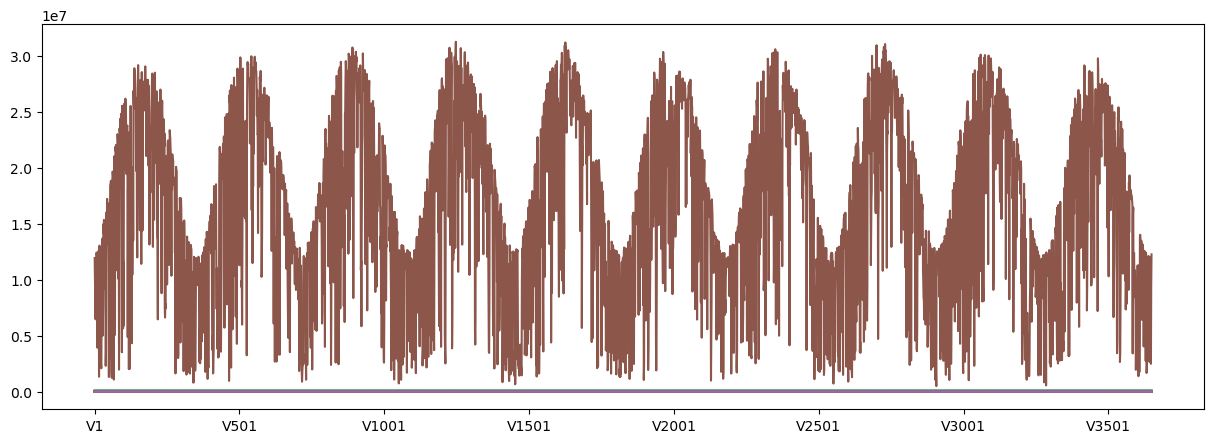

In [10]:
# In the plot, we can see that there are a lot of 0 values in the dataset
train_df.plot(legend=False, figsize=(15, 5))

In [11]:
result = train_df.eq(0.0).sum() / len(train_df) * 100

# Select those columns with more than 30% of zeros
result = result[result > 30.0]
result = result.sort_values(ascending=False)
result

dswrf_s1_1    91.808219
uswrf_s1_1    90.767123
apcp_sf4_1    63.041096
apcp_sf5_1    61.041096
apcp_sf1_1    60.821918
apcp_sf2_1    59.890411
apcp_sf3_1    56.739726
tcdc_ea3_1    37.917808
tcdc_ea1_1    37.808219
tcdc_ea2_1    37.424658
tcdc_ea5_1    36.301370
tcdc_ea4_1    35.726027
dtype: float64

### Observations

As output of the previous cell, we can see that there exist a lot of zeros in the dataset, let's analize if those zeros make sense or not.

The variables with most ammount of zeros (>30%) are:

- **dswrf_s1_1**: Downward short-wave radiative flux average at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **uswrf_s1_1**: Upward short-wave radiation at the surface, at 12:00 UTC, normal to have a lot of zeros as it is not sunny at 12:00
- **apcp_s**: 3-Hour accumulated precipitation at the surface, as it is not raining every day, it is normal to have a lot of zeros
- **tcdc_ea**: Total cloud cover over the entire depth of the atmosphere, as it is not cloudy every day, it is normal to have a lot of zeros


First, lets start by assigning the zeros to NaNs. By doing this we can visualize the varibles that take more values other than zero.


In [12]:
disp_df_nan = train_df.replace(0.0, np.nan)

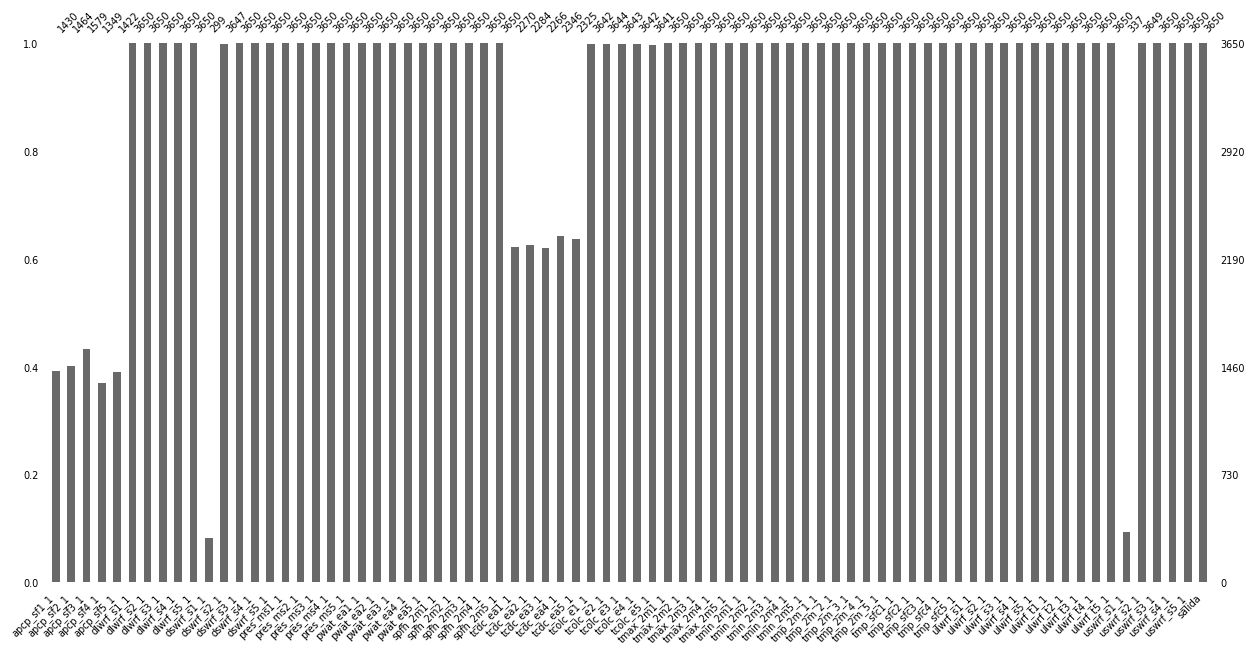

In [13]:
""" Plotting missing values """
# Sustitute 0.0 values with NaN and plot the name of the columns with missing values
# ? msno.bar is a simple visualization of nullity by column
msno.bar(disp_df_nan, labels=True, fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_bar.png")

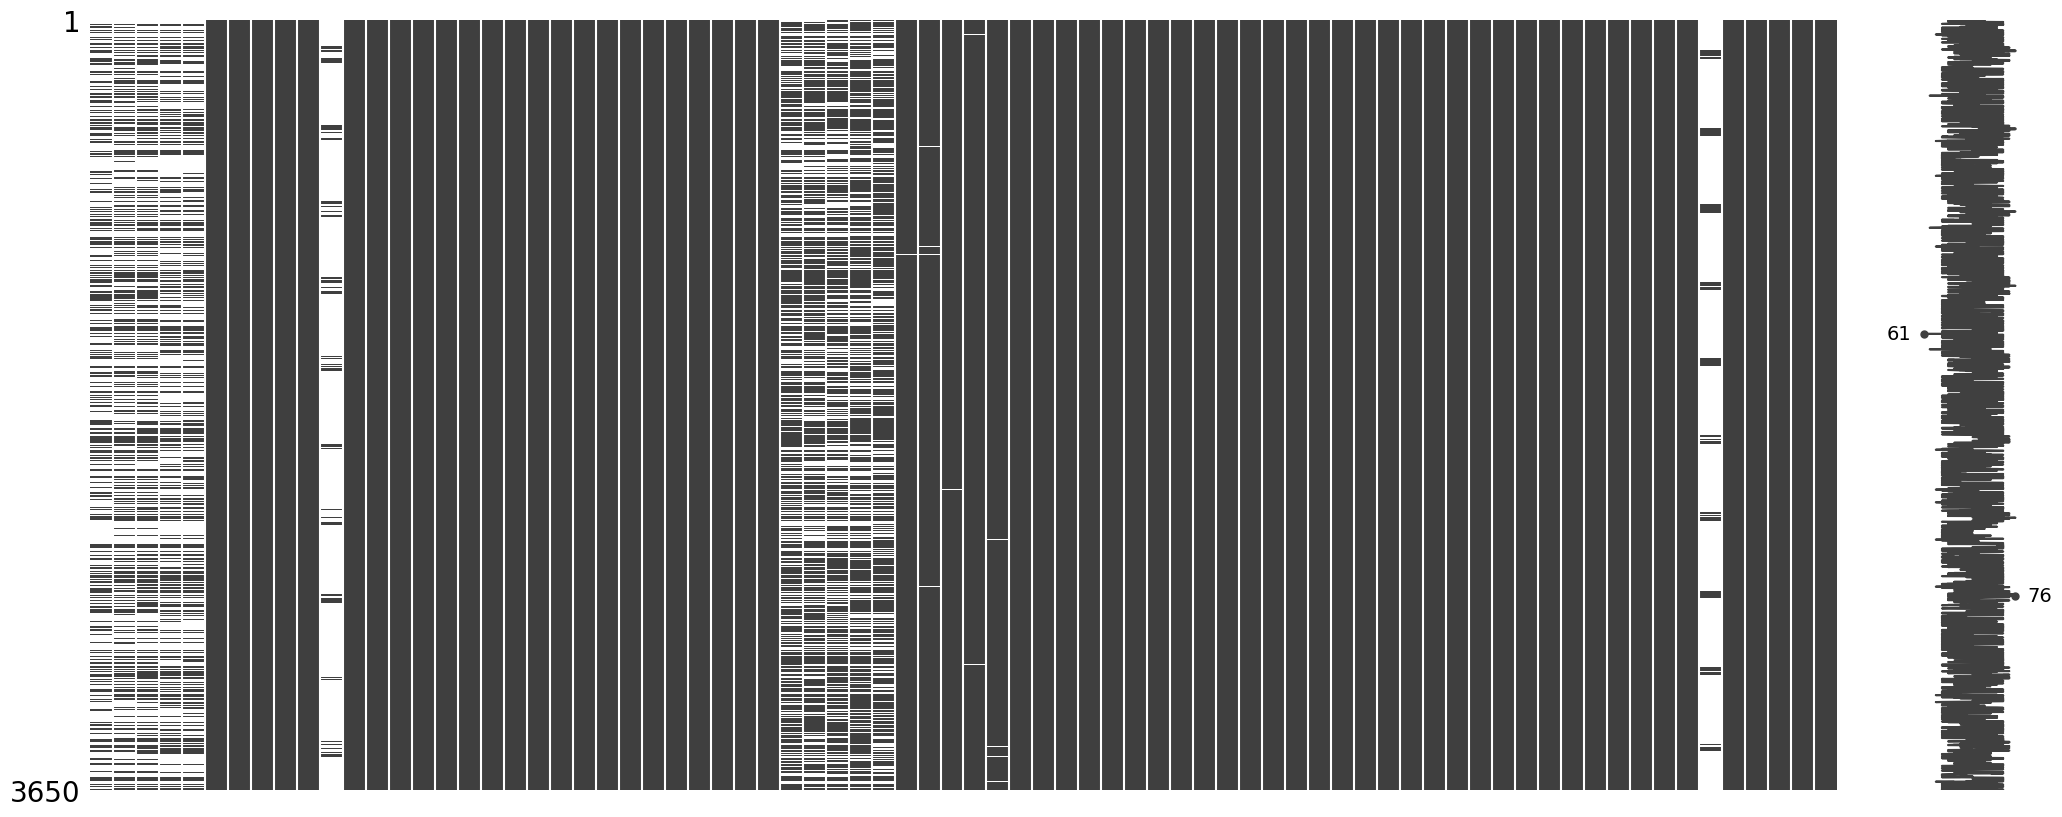

In [14]:
""" Plotting the missing values in a matrix """

# ? The msno.matrix nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.
msno.matrix(disp_df_nan)

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_matrix.png")

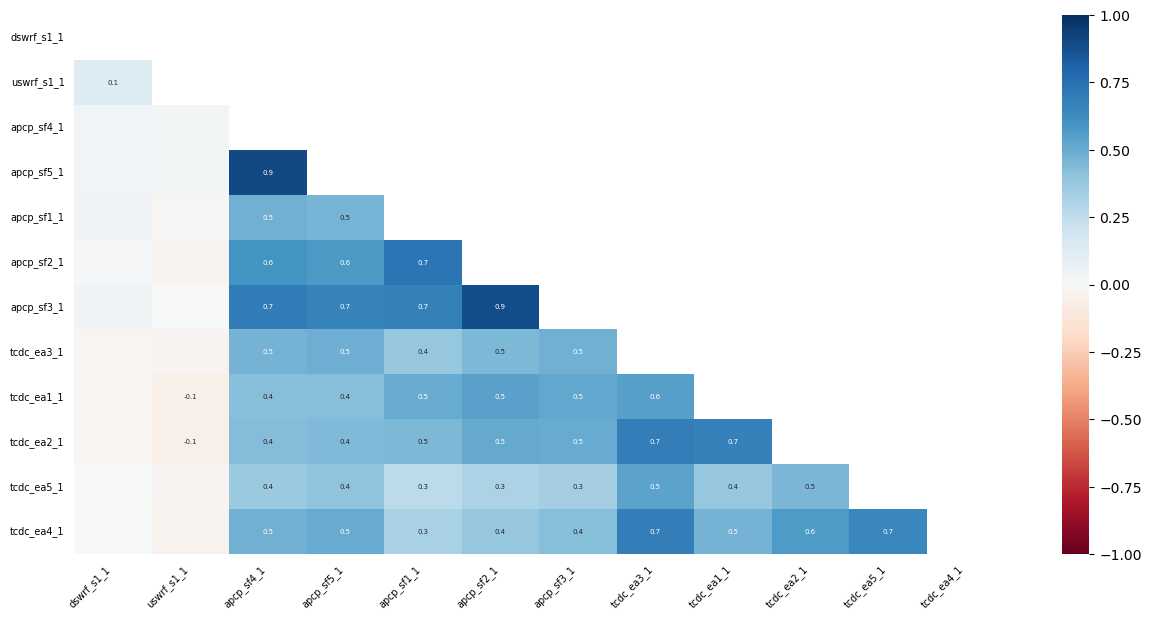

In [15]:
""" Plotting the missing values in a heatmap """
# As in a hetmap not every value is shown, we must delimit the values to the ones with more than 30% of missing values
result = disp_df.eq(0.0).sum() / len(disp_df) * 100
result = result[result > 30.0]  # Select those columns with more than 30% of zeros
result = result.sort_values(ascending=False)
result = result.index.tolist()  # Convert to list
result

# ? The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another
msno.heatmap(disp_df_nan[result], fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_heatmap.png")

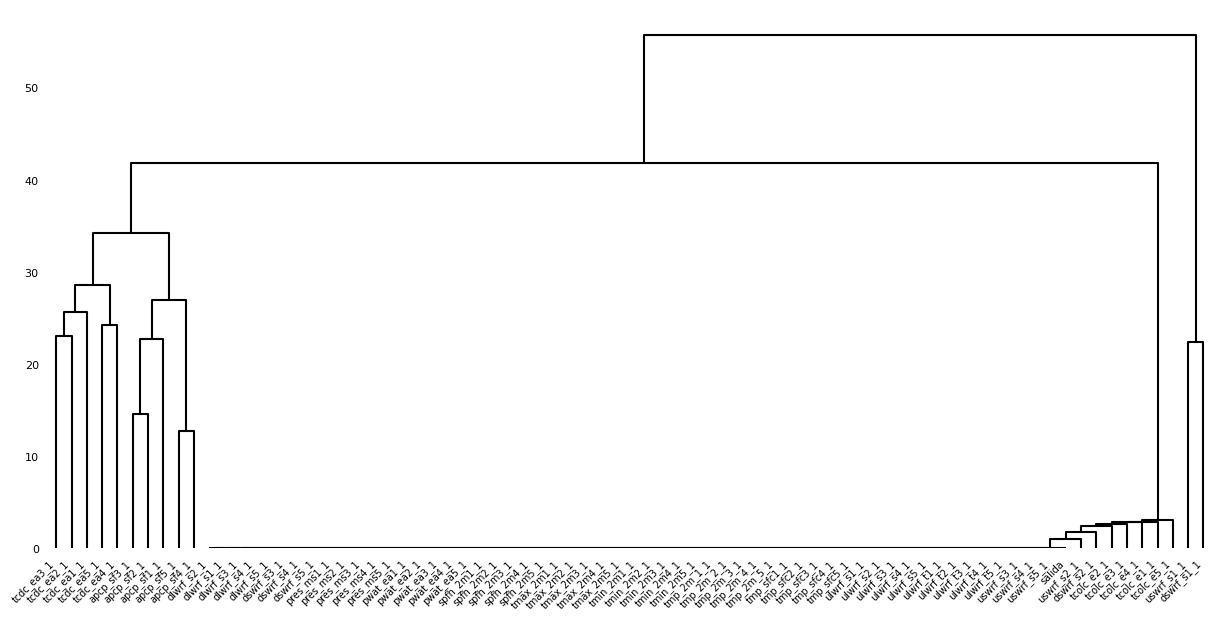

In [16]:
""" Plotting the dendrogram """

# ? The dendrogram allows you to more fully correlate variable completion, revealing trends deeper than the pairwise ones visible in the correlation heatmap:
msno.dendrogram(disp_df_nan, orientation="top", fontsize=7, figsize=(15, 7))

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/missing_values_dendrogram.png")

### Conclusions
In this section, we have observe that there are no attibutes with 'Null' nor 'NaN' nor 'None' values. This indicated that at a first glance, the data is clean, at least of those datatypes.

In second place, we have observed that the attributes that we suspected could have an important number of missing values (represented by 0 instead of the previously mentioned), had instead valuable information, as we have proved along this section.<br>Since the data is clean and we have concluded there are no missing values, we do not need to complete them using a model or other methods, so we can move on to the next step, observing the outliers.

## 3.3. Outliers


With the objective of noticing the outliers on each attribute, we create a box-plot of each of the attributes 

In [17]:
list_of_attributes = train_df.columns.values.tolist()
#print(list_of_attributes)

In [18]:
# Boxplot with all attributes in the dataset
# sns.boxplot(data=train_df, orient="h")
# plt.show()

In [19]:
train_df.describe()

,apcp_sf1_1,apcp_sf2_1,apcp_sf3_1,apcp_sf4_1,apcp_sf5_1,dlwrf_s1_1,dlwrf_s2_1,dlwrf_s3_1,dlwrf_s4_1,dlwrf_s5_1,dswrf_s1_1,dswrf_s2_1,dswrf_s3_1,dswrf_s4_1,dswrf_s5_1,pres_ms1_1,pres_ms2_1,pres_ms3_1,pres_ms4_1,pres_ms5_1,pwat_ea1_1,pwat_ea2_1,pwat_ea3_1,pwat_ea4_1,pwat_ea5_1,spfh_2m1_1,spfh_2m2_1,spfh_2m3_1,spfh_2m4_1,spfh_2m5_1,tcdc_ea1_1,tcdc_ea2_1,tcdc_ea3_1,tcdc_ea4_1,tcdc_ea5_1,tcolc_e1_1,tcolc_e2_1,tcolc_e3_1,tcolc_e4_1,tcolc_e5_1,tmax_2m1_1,tmax_2m2_1,tmax_2m3_1,tmax_2m4_1,tmax_2m5_1,tmin_2m1_1,tmin_2m2_1,tmin_2m3_1,tmin_2m4_1,tmin_2m5_1,tmp_2m_1_1,tmp_2m_2_1,tmp_2m_3_1,tmp_2m_4_1,tmp_2m_5_1,tmp_sfc1_1,tmp_sfc2_1,tmp_sfc3_1,tmp_sfc4_1,tmp_sfc5_1,ulwrf_s1_1,ulwrf_s2_1,ulwrf_s3_1,ulwrf_s4_1,ulwrf_s5_1,ulwrf_t1_1,ulwrf_t2_1,ulwrf_t3_1,ulwrf_t4_1,ulwrf_t5_1,uswrf_s1_1,uswrf_s2_1,uswrf_s3_1,uswrf_s4_1,uswrf_s5_1,salida
count,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3650.000000,3.650000e+03
mean,0.610222,0.251049,0.479367,0.279969,0.525625,316.590458,316.996492,324.225574,343.169304,342.582550,0.074371,163.928966,376.718929,686.534869,508.429988,101718.580471,101774.517076,101743.013770,101538.253073,101499.397514,21.394485,21.536129,22.127195,22.595594,22.384870,0.007844,0.008848,0.009356,0.009473,0.009918,0.069240,0.067845,0.064862,0.065706,0.062366,0.069539,0.068172,0.065166,0.066036,0.062748,286.950030,288.292227,292.803749,294.483694,294.542492,284.595935,284.638684,284.617400,292.733513,291.084714,284.846286,288.227387,292.740802,294.299550,291.301035,284.094056,289.230769,295.533258,295.904819,290.366407,375.991521,381.989673,400.742449,439.104661,431.318749,247.736467,247.626828,251.950057,262.207928,261.074238,0.078107,38.716712,76.394795,127.098207,99.476613,1.638200e+07
std,2.245850,0.994112,1.756408,1.120933,1.931408,56.119896,58.129352,58.941747,61.150202,61.027007,0.305126,112.645372,159.486316,227.642854,193.753483,725.206610,731.500969,720.701217,699.477989,715.361146,12.256253,12.358856,12.583364,12.633154,12.401121,0.004398,0.005039,0.005175,0.005097,0.005456,0.167104,0.169653,0.171287,0.172516,0.166113,0.166989,0.169522,0.171172,0.172385,0.165958,8.925065,9.743169,9.898253,9.789117,9.776615,8.735982,8.862301,8.866503,9.950300,10.099684,8.722593,9.795209,9.944761,9.795537,10.083859,8.861650,9.756852,9.148308,9.317363,10.462108,46.586515,49.914820,50.766618,53.159310,54.417631,36.270918,36.289003,35.798277,38.698726,38.427066,0.258752,26.010130,30.743175,40.765618,35.505727,8.059674e+06
min,0.000000,0.000000,0.000000,0.000000,0.000000,158.971770,160.032903,165.524543,183.671312,186.342961,0.000000,0.000000,20.000000,30.000000,20.000000,99316.970881,99315.887074,99327.755682,99040.100852,98830.153409,1.100000,1.314819,1.107352,1.142803,1.201246,0.000462,0.000485,0.000451,0.000478,0.000468,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,254.589220,254.937418,258.549777,260.800365,260.863475,251.941358,249.576132,249.576714,258.698331,258.171345,251.942065,254.844406,258.552646,260.795430,258.170049,250.100794,256.360800,263.634377,264.533564,256.520408,229.296161,223.985486,246.314349,278.576630,271.707606,104.671267,113.559602,118.679132,

In [20]:
train_df['apcp_sf1_1'].value_counts()

0.000000    2220
0.000909      54
0.001818      24
0.003636      19
0.002727      19
            ... 
2.356364       1
0.920000       1
0.048182       1
0.211818       1
1.363636       1
Name: apcp_sf1_1, Length: 1170, dtype: int64

Here, by plotting the boxplots and making the outliers (fliers) visible, we are able to see some outliers in the dataset.<br>
Take into account that the outliers are represented by the points outside the boxplot and they can be potentially wrong values or just values that are not usual in the dataset (ruido).

### 3.3.1. Histogram to identify outliers

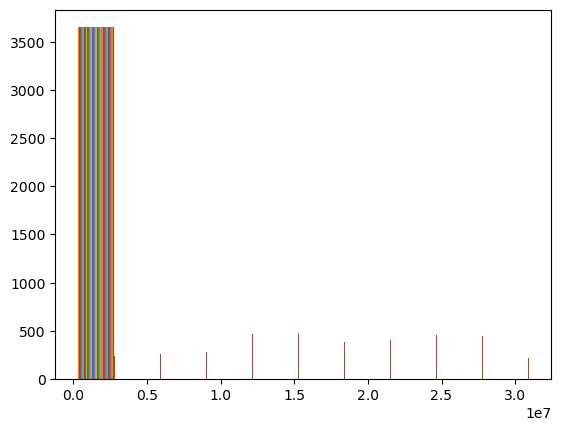

In [30]:
""" Histogram showing the distribtuion of train_df to show the outliers """
plt.hist(train_df)
plt.show()

### 3.3.2. Boxplot to identify outliers

['apcp_sf1_1 outliers', 693]...
['apcp_sf2_1 outliers', 674]...
['apcp_sf3_1 outliers', 677]...
['apcp_sf4_1 outliers', 761]...
['apcp_sf5_1 outliers', 709]...
['dswrf_s1_1 outliers', 299]...
['pres_ms1_1 outliers', 56]...
['pres_ms2_1 outliers', 55]...
['pres_ms3_1 outliers', 64]...
['pres_ms4_1 outliers', 68]...
['pres_ms5_1 outliers', 58]...
['tcdc_ea1_1 outliers', 514]...
['tcdc_ea2_1 outliers', 525]...
['tcdc_ea3_1 outliers', 575]...
['tcdc_ea4_1 outliers', 549]...
['tcdc_ea5_1 outliers', 559]...
['tcolc_e1_1 outliers', 513]...
['tcolc_e2_1 outliers', 523]...
['tcolc_e3_1 outliers', 575]...
['tcolc_e4_1 outliers', 555]...
['tcolc_e5_1 outliers', 560]...
['uswrf_s1_1 outliers', 337]...
['uswrf_s3_1 outliers', 3]...
['uswrf_s4_1 outliers', 31]...
['uswrf_s5_1 outliers', 9]...
Total number of atributes with outliers: 25 / 75


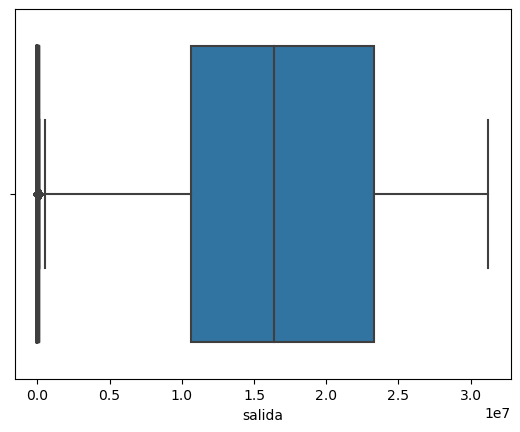

In [22]:
""" Plotting the boxplot for each attribute and getting the outliers of each attribute """
total_outliers = []
# * We iterate over the list of attributes
for attribute in list_of_attributes:
    # * sns.regplot(x=train_df[attribute], y=train_df['total'], fit_reg=False)
    sns.boxplot(data=train_df[attribute], x=train_df[attribute], orient="h")
    # * Use the command below to show each plot (small size for visualization sake)
    # sns.set(rc={'figure.figsize':(1,.5)})
    # plt.show()
    # * All the images are saved in the folder ../data/img/box-plot
    plt.savefig(f"../data/img/box-plot/{str(attribute)}.png")

    # We obtain the a list of outliers for each attribute
    list_of_outliers = train_df[attribute][train_df[attribute] > train_df[attribute].quantile(0.75) + 1.5*(train_df[attribute].quantile(0.75) - train_df[attribute].quantile(0.25))].tolist()
    outliers = [f'{attribute} outliers'] + [len(list_of_outliers)] + [list_of_outliers]
    # * In order to print the total number of outliers for each attribute
    # print(f'{attribute} has {len(list_of_outliers)} outliers')
    # ! Data structure: [attribute, number of outliers, list of outliers]
    # print(outliers)
    total_outliers.append(outliers)

# print the first 2 elements of each element in the list -> [[atb, num],[atb, num],...]
num_atb_outliers = 0
for i in total_outliers:
    if i[1] != 0:
        num_atb_outliers += 1
        print(f"{i[0:2]}...")
        
# Number of outliers != 0 for each attribute
print(f"Total number of atributes with outliers: {num_atb_outliers} / {len(total_outliers)-1}")

We managed to create a list containing the name of the atribute, the number of outliers and the value of the outliers for each attribute, calculated by applying the IQR method.<br> This is relevant as we managed to create a 'total_outliers' variable that contains the list data structures of all the different outliers from all the attributes, so that it can be easily accessed in a future to remove the outliers from the dataset if needed for testing purposes.

As suspected, we can see that **there are a lot of outliers in the dataset**, therefore it is plausible that some of them are noise, thus possibly being removed in a future model in order to improve it (either by hand or by selection in the preprocess pipeline).<br>Now, we need to analyze if they are the result of bad measurements or if they are significant data for the analysis.


Additionaly, as we will see later, this amount of outliers indicate us that probably a Robust Scaler will be more appropriate than using a Standard Scaler, as the Robust Scaler is more robust to outliers than the Standard Scaler, thus being more appropriate for this dataset model.

### 3.3.3. Skewness and Kurtosis to identify outliers
Skewness and kurtosis are commonly used to measure the shape of a distribution. Skewness measures the degree of asymmetry in the distribution, while kurtosis measures the degree of flatness in the distribution compared to a normal distribution.
We will look for observations that are far from the central tendency of the distribution and may indicate the presence of extreme values or data points that do not fit the pattern of the majority of the data (which as expected, happens to be the case in this dataset).

In [23]:
""" Skewness """
# ? skewness: measure of the asymmetry of the probability distribution of a real-valued random variable about its mean.
train_df.skew().sort_values(ascending=False)

apcp_sf4_1    9.297678
apcp_sf2_1    7.610005
apcp_sf5_1    7.244491
apcp_sf3_1    7.241727
apcp_sf1_1    6.783553
                ...   
ulwrf_t1_1   -0.964701
ulwrf_t3_1   -0.989917
ulwrf_t2_1   -1.001763
ulwrf_t5_1   -1.071147
ulwrf_t4_1   -1.196425
Length: 76, dtype: float64

In [24]:
""" Kurtosis """
# ? kurtosis: measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
train_df.kurt().sort_values(ascending=False)

apcp_sf4_1    138.601323
apcp_sf2_1     79.535762
apcp_sf5_1     78.321580
apcp_sf3_1     72.498316
apcp_sf1_1     61.204708
                 ...    
uswrf_s2_1     -1.306893
spfh_2m2_1     -1.320499
spfh_2m5_1     -1.321073
dswrf_s2_1     -1.323864
spfh_2m3_1     -1.329847
Length: 76, dtype: float64

/tmp/ipykernel_5125/2978756091.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=True, fit=st.norm)
/tmp/ipykernel_5125/2978756091.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=True, fit=st.lognorm)


<Axes: title={'center': 'Log Normal'}, xlabel='apcp_sf4_1', ylabel='Density'>

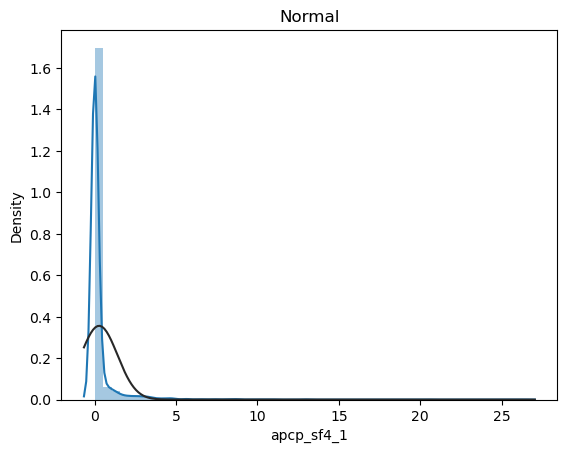

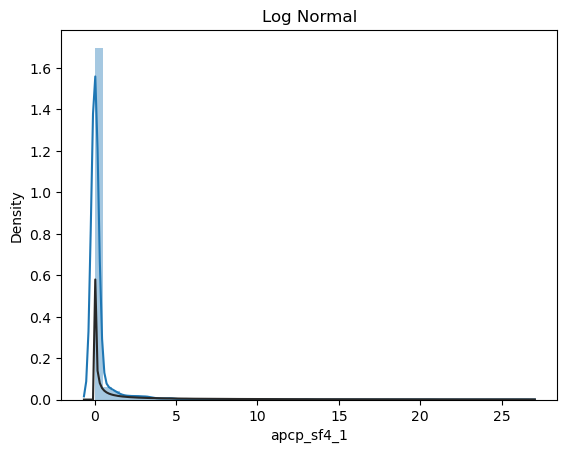

In [25]:
y = train_df["apcp_sf4_1"]
plt.figure(1)
plt.title("Normal")
sns.distplot(y, kde=True, fit=st.norm)
plt.figure(2)
plt.title("Log Normal")
sns.distplot(y, kde=True, fit=st.lognorm)

/tmp/ipykernel_5125/388743980.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df.skew(), color="blue", axlabel="Skewness")


<Axes: xlabel='Skewness', ylabel='Density'>

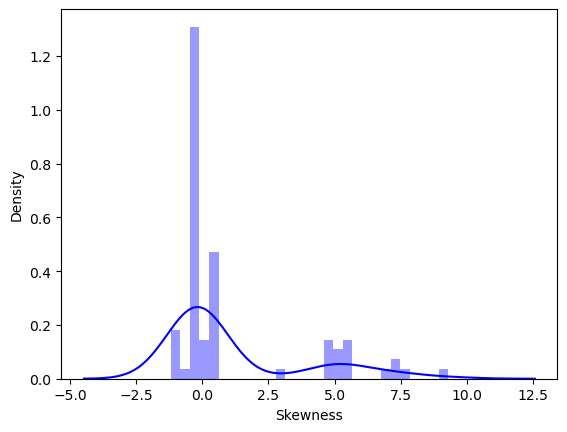

In [26]:
sns.distplot(train_df.skew(), color="blue", axlabel="Skewness")

/tmp/ipykernel_5125/4054214216.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


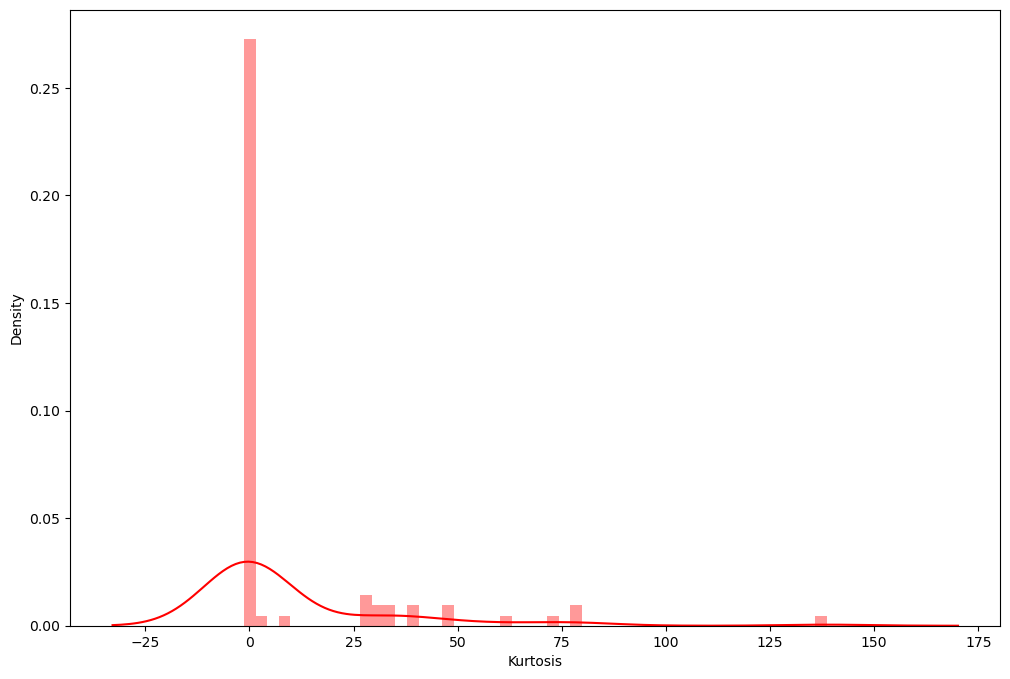

In [27]:
plt.figure(figsize=(12, 8))
sns.distplot(
    train_df.kurt(), color="r", axlabel="Kurtosis", norm_hist=False, kde=True, rug=False
)
# plt.hist(train.kurt(),orientation = 'vertical',histtype = 'bar',label ='Kurtosis', color ='blue')
plt.show()

## 3.4. Correlation


In this section we are getting information about the correlation of the variables between them. This information is valuable in order to make good decisions when deleting redundant attributes. Also note we are getting information about the correlation between each attribute and the solution variable. This allows us to know the most relevant attributes, making the best decisions when creating the different models.  

In [ ]:
correlation = train_df.corr()
correlation = abs(correlation)
print(correlation.shape)  # 76 x 76 matrix of correlation values

### Getting the correlation matrix formatted into our own data structure
This is done for the sake of simplicity and to be able to visualize the correlation matrix in a more intuitive way.


In [ ]:
correlation_list = []

for column in train_df.columns:
    correlation.loc[:, column] = abs(
        correlation.iloc[:, train_df.columns.get_loc(column)]
    )
    mask = correlation.loc[:, column] > 0.95
    # print(correlation[column][mask].sort_values(ascending = False))

    # Translate the comment below to English:
    # we add the correlation values to a list of lists, which contains the names of the correlated columns and their correlation index

    # The first segment adds the name of the column we are analyzing
    # The second segment adds the names of the columns correlated (except the column we are analyzing) > 0.95
    # The third segment adds the correlation index of the columns correlated (except the column we are analyzing) > 0.95
    # Second and third segment are added to the first segment as a list of lists

    # First we need to create a dictionary with the column names and their correlation values (except the column we are analyzing)
    dict = {
        key: value
        for key, value in correlation.loc[column, mask]
        .sort_values(ascending=False)
        .iloc[1:]
        .to_dict()
        .items()
    }
    # print (dict)

    # Then we create a list of lists with the column names and their correlation values from the dictionary created above
    corr_list = [[key] + [value] for key, value in dict.items()]
    # Finally we add the name of the column we are analyzing to the list of lists created above as the first element of the list (str)
    corr_list.insert(0, ["Columna: " + column])

    # ! Data structure: [[columna, [columna correlada 1, indice de correlacion], [columna correlada 2, indice de correlacion], ...], ...]
    print(corr_list)

    correlation_list += [corr_list]
print(correlation_list)

### Correlation Heat Map

In [ ]:
""" seaborne Correlation Heat Map """
# It needs to show all the columns
fig, ax = plt.subplots(figsize=(19, 18))

plt.title("Correlation Heat Map", y=1)
# We use blue color scale because it is easier to see the annotations and the correlation values
sns.heatmap(
    correlation,
    square=True,
    cmap="Blues",
    annot=True,
    fmt=".2f",
    annot_kws={"size": 4},
    cbar_kws={"shrink": 0.5},
    vmin=0.0,
    vmax=1,
)
# We can modify vmax=0.95 in order to get same color scale for values with more than 0.95 correlation
# Note: it delays around 15 seconds as it needs to plot a 76*76 matrix with its 5766 correlation values

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/correlation_heatmap.png", dpi=200)

We can observe clearly how there are a lot of correlations between the different attributes, which is expected as they are all weather related variables.<br> This is important to know as it will allow us to know which attributes are redundant and which ones are not, so that we can delete the redundant ones in order to improve the model. <br><br> Once obtained the most correlated columns of the dataset, we can plot them and visualize their correlation.

In [ ]:
# 1
columns = ['apcp_sf1_1', 'apcp_sf2_1', 'apcp_sf3_1','apcp_sf4_1', 'apcp_sf5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 2
columns = [ 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 3
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'dlwrf_s1_1', 'dlwrf_s2_1', 'dlwrf_s3_1', 'dlwrf_s4_1', 'dlwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 4
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 5
columns = ['dswrf_s1_1', 'dswrf_s2_1', 'dswrf_s3_1', 'dswrf_s4_1', 'dswrf_s5_1', 'uswrf_s1_1', 'uswrf_s2_1', 'uswrf_s3_1', 'uswrf_s4_1', 'uswrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 6
columns = ['pres_ms1_1', 'pres_ms2_1', 'pres_ms3_1', 'pres_ms4_1', 'pres_ms5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 7
columns = ['pwat_ea1_1', 'pwat_ea2_1','pwat_ea3_1','pwat_ea4_1','pwat_ea5_1', 'spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 8
columns = ['spfh_2m1_1', 'spfh_2m2_1', 'spfh_2m3_1', 'spfh_2m4_1', 'spfh_2m5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

sns.pairplot(train_df[columns], height = 1, kind ='scatter',diag_kind='kde')
plt.show()

In [ ]:
# 9
# columns = ['tmax_2m1_1', 'tmax_2m2_1', 'tmax_2m3_1', 'tmax_2m4_1', 'tmax_2m5_1', 'tmin_2m1_1', 'tmin_2m2_1', 'tmin_2m3_1', 'tmin_2m4_1', 'tmin_2m5_1','tmp_2m_1_1', 'tmp_2m_2_1', 'tmp_2m_3_1', 'tmp_2m_4_1', 'tmp_2m_5_1', 'tmp_sfc1_1', 'tmp_sfc2_1', 'tmp_sfc3_1', 'tmp_sfc4_1', 'tmp_sfc5_1','ulwrf_s1_1', 'ulwrf_s2_1', 'ulwrf_s3_1', 'ulwrf_s4_1', 'ulwrf_s5_1']

# sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
# plt.show()

In [ ]:
# 10
columns = ["ulwrf_t1_1", "ulwrf_t2_1", "ulwrf_t3_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In [ ]:
# 11
columns = ['ulwrf_t4_1', 'ulwrf_t5_1', ]

sns.pairplot(train_df[columns], height = 1 ,kind ='scatter',diag_kind='kde')
plt.show()


In [ ]:
# 12
columns = ["uswrf_s2_1", "uswrf_s3_1", "uswrf_s4_1", "uswrf_s5_1"]

sns.pairplot(train_df[columns], height=1, kind="scatter", diag_kind="kde")
plt.show()

In the graphs above, we can observe than the most correlated variables present a linear relationship between them. This shows as a diagonal in the graph, since both variables grow at the same time.<br>
As we already commented, this is expected as the variables are all weather related, so it is normal that they are correlated and must be taken into account when creating the model (eliminating the redundant ones).

---
# 4. Train-Test division 

Since we are working with a time dependent data, we need to avoid mixing it. Also, we are required to add the first 10 years of data to the train set and the last 2 years to the test set. This means we are assigning a 83.333333 percent of the data to train and a 16.66666666 to test.

**Note**: This division was already done before the EDA. We overwrite it to start from a clean state.

Note: `iloc` is useful when we want to split data based on the index or other criteria, while `train_test_split` is useful when wanting to randomly split data into training and testing subsets.<br>
Therefore, we will use `iloc` to split the data into train and test sets as we are dealing with time dependent data.

In [40]:
import time
import matplotlib.pyplot as plt

# Import the metrics from sklearn
from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.pipeline import Pipeline

# As we have noted during the EDA, for this dataset full of outliers, its preferable to use the RobustScaler
# Although this wont make a huge difference
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV

## 4.1. Train-Test split

In [41]:
""" Train Test Split (time series) """

np.random.seed(10)

# * Make a copy of the dataframe (as Padas dataframe is mutable, therefore uses a reference)
disp_df_copy = disp_df.copy()

# print(disp_df)
# print(disp_df_copy)

# Now we make the train_x, train_y, test_x, test_y splits taking into account the time series
# Note: the time series is ordered by date, therefore we need to split the data in a way that the train data is before the test data
# Note: the 10 first years are used for training and the last two years for testing
# Note: this is done because if not, we will be predicting the past from the future, which leads to errors and overfitting (data leakage) in the model

# * Calculate the number of rows for training and testing
num_rows = disp_df_copy.shape[0]
num_train_rows = int(
    num_rows * 10 / 12
)  # 10 first years for training, 2 last years for testing

# * Split the data into train and test dataframes (using iloc instead of train_test_split as it picks random rows)
train_df = disp_df_copy.iloc[
    :num_train_rows, :
]  # train contains the first 10 years of rows
test_df = disp_df_copy.iloc[
    num_train_rows:, :
]  # test contains the last 2 years of rows

# Print the number of rows for each dataframe
print(f"Number of rows for training: {train_df.shape[0]}")
print(f"Number of rows for testing: {test_df.shape[0]}")

# Print the dataframes
# print(train_df), print(test_df)

# * Separate the input features and target variable for training and testing
X_train = train_df.drop("salida", axis=1)  # This is the input features for training
y_train = train_df["salida"]  # This is the target variable for training
X_test = test_df.drop("salida", axis=1)  # This is the input features for testing
y_test = test_df["salida"]  # This is the target variable for testing

# Print the shapes of the dataframes
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Number of rows for training: 3650
Number of rows for testing: 730
(3650, 75) (3650,) (730, 75) (730,)


## 4.2. Train-Test RMSE and MAE function

In [42]:
np.random.seed(10)


def train_and_test(model, score, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
    mae_train = mean_absolute_error(y_train, y_train_pred)

    y_test_pred = model.predict(X_test)
    rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
    mae_test = mean_absolute_error(y_test, y_test_pred)

    print(f"Results of the best estimator of {model.__class__.__name__}")
    print(f"NMAE in validation: {score:.2f}")
    print(f"RMSE train: {rmse_train:.2f}", f"MAE train: {mae_train:.2f}", sep="\t")
    print(f"RMSE test: {rmse_test:.2f}", f"MAE test: {mae_test:.2f}", sep="\t")

    # ! Train accuracy using scatter plot
    plt.plot(X_train.iloc[:, [0]], y_train, ".", label="train")
    plt.plot(X_train.iloc[:, [0]], y_train_pred, "r.", label="train pred")
    plt.legend()
    plt.show()

    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_train - y_train_pred
    
    plt.hist(prediction_errors, bins=25)
    plt.xlabel('Prediction Errors')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Errors (RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f})')
    plt.show()


    # ! Test accuracy using scatter plot
    plt.plot(X_test.iloc[:, [0]], y_test, ".", label="test")
    plt.plot(X_test.iloc[:, [0]], y_test_pred, "r.", label="test pred")
    plt.legend()
    plt.show()
 
    # ! Prediction errors using a histogram
    # Calculate the difference between test predictions and test data
    prediction_errors = y_test - y_test_pred

    plt.hist(prediction_errors, bins=25)
    plt.xlabel('Prediction Errors')
    plt.ylabel('Frequency')
    plt.title(f'Prediction Errors (RMSE: {rmse_test:.2f}, MAE: {mae_test:.2f})')
    plt.show()

    return [score, rmse_train, mae_train, rmse_test, mae_test]

## 4.3. Print model results

In [43]:
def print_results(name, model, score, time):
    print("---------------------------------------------------")
    print(f"{name} best model is:\n\n{model}")
    print("\nParameters:", model.best_params_)

    print(
        f"\nPerformance: NMAE (val): {score[0]}",
        f"RMSE train: {score[1]}",
        f"MAE train: {score[2]}",
        f"RMSE train: {score[3]}",
        f"MAE test: {score[4]}",
        sep=" | ",
    )

    print(f"Execution time: {time}s")

---
# 5. Basic methods:

In [44]:
# Three dictionaries to store the results of the models
models, results, times = {}, {}, {}

## 5.1. KNN


In [45]:
from sklearn.neighbors import KNeighborsRegressor

### 5.1.1. KNN - Predefined parameters
The KNN predefinded hyperparameters are the following: 

Results of the best estimator of Pipeline
NMAE in validation: -2768275.09
RMSE train: 2995411.40	MAE train: 2105354.33
RMSE test: 3669004.35	MAE test: 2589913.23


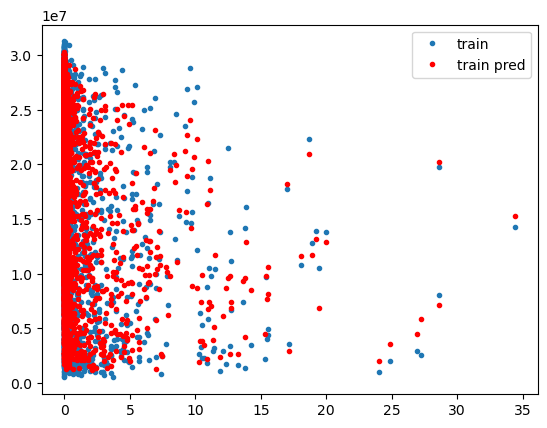

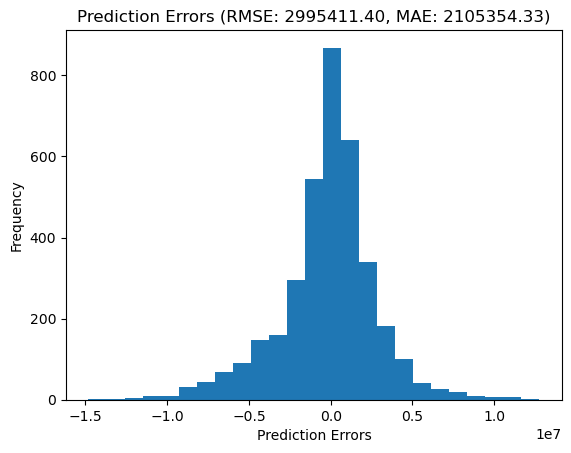

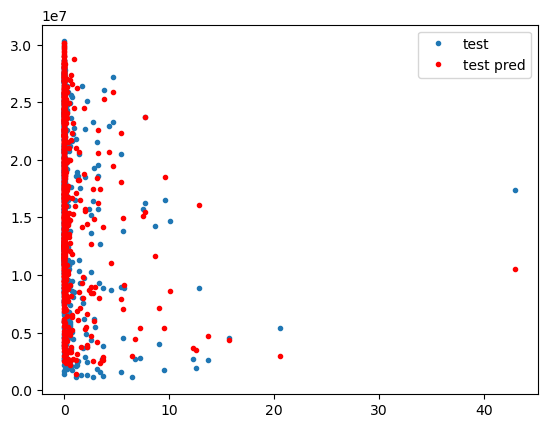

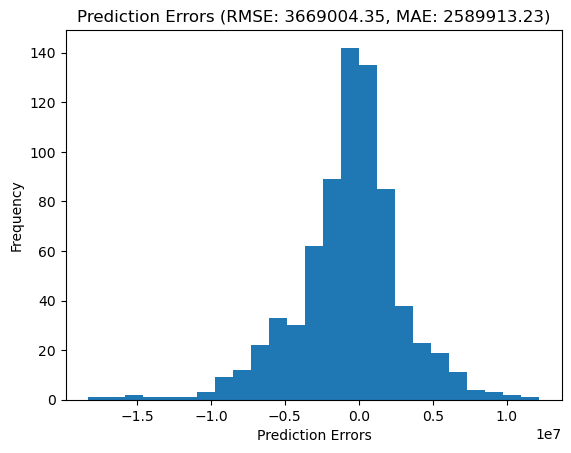

---------------------------------------------------
KNN PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model', KNeighborsRegressor())]),
             param_grid={'model__metric': ['minkowski'],
                         'model__n_neighbors': [5],
                         'model__weights': ['uniform']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}

Performance: NMAE (val): -2768275.085526316 | RMSE train: 2995411.3954362 | MAE train: 2105354.3342465754 | RMSE train: 3669004.351737694 | MAE test: 2589913.2328767125
Execution time: 0.13675975799560547s


In [46]:
np.random.seed(10)
n_splits = 5

# Using a pipeline to scale the data and then apply the model
pipeline = Pipeline(
    [
        ("scale", StandardScaler()),
        # ('select', SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": [5],
    "model__weights": ["uniform"],
    "model__metric": ["minkowski"],
    # 'select__k': list(range(1, X_train.shape[1]+1))
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),  # We use TimeSeriesSplit to split the data in folds without losing the temporal order
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_pred"] = model
results["KNN_pred"] = score
times["KNN_pred"] = total_time

print_results("KNN PREDEFINED PARAMETERS", model, score, total_time)

Since the NMAE is normalized by the mean absolute error of the test set, it is expected to be different from the MAE calculated directly using the mean_absolute_error function. The NMAE is a way to evaluate the performance of a model in a cross-validation setting, while the MAE is a direct measure of the model's performance on the training set.

Therefore, as we can not use the results of RMSE nor MAE in test, we will use the NMAE scoring given in validation to select the best model (as it is a fairly correct aproximation).

###  5.1.2. KNN - Selected parameters

Results of the best estimator of Pipeline
NMAE in validation: -2693826.20
RMSE train: 3386909.05	MAE train: 2410845.29
RMSE test: 3394685.60	MAE test: 2420543.42


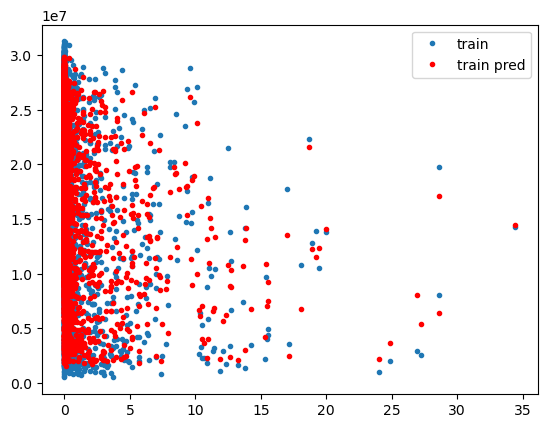

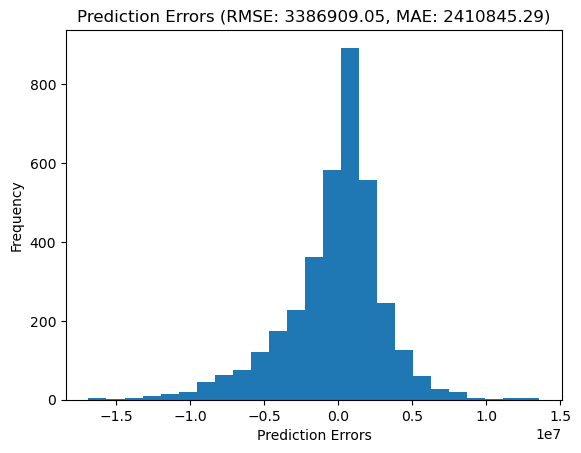

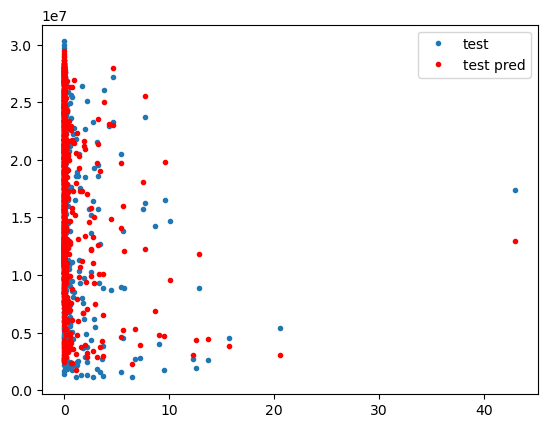

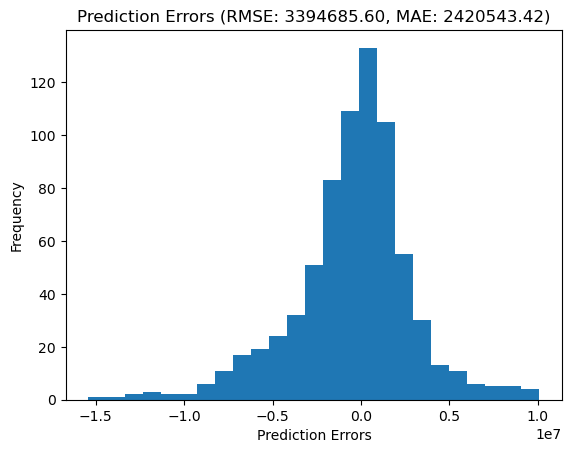

---------------------------------------------------
KNN SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('select',
                                              SelectKBest(score_func=<function f_regression at 0x7effbd8d3f40>)),
                                             ('model', KNeighborsRegressor())]),
                   n_iter=15,
                   param_distributions={'model__metric': ['euclidean',
                                                          'manhattan',
                                                          'minkowski',
                                                          'chebyshev'],
                                        'model__n_neighbors': [1, 3, 5, 7, 9,
                                                               11, 13, 15, 17,
                 

In [47]:
np.random.seed(10)
budget = 15
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", RobustScaler()),
        ("select", SelectKBest(f_regression)),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
    "model__n_neighbors": list(range(1, 50, 2)),
    "model__weights": ["uniform", "distance"],
    "model__metric": ["euclidean", "manhattan", "minkowski", "chebyshev"],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(
        n_splits
    ),  # TimeSeriesSplit to split the data in folds without losing the temporal order
    n_iter=budget,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["KNN_select"] = model
results["KNN_select"] = score
times["KNN_select"] = total_time

print_results("KNN SELECTED PARAMETERS", model, score, total_time)

## 5.2 Regression Trees

In [48]:
from sklearn.tree import DecisionTreeRegressor

### 5.2.1. Regression Trees - Predefined parameters

Results of the best estimator of Pipeline
NMAE in validation: -3415756.78
RMSE train: 0.00	MAE train: 0.00
RMSE test: 4481491.81	MAE test: 3136053.29


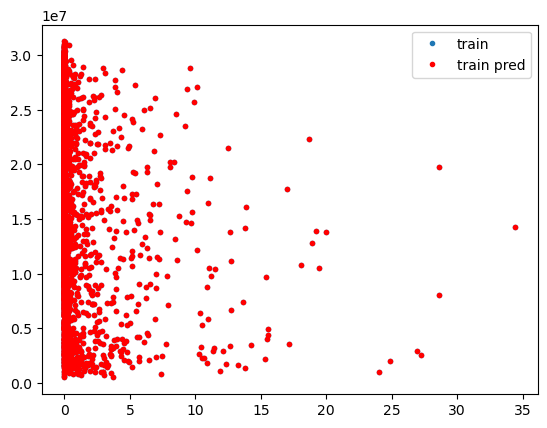

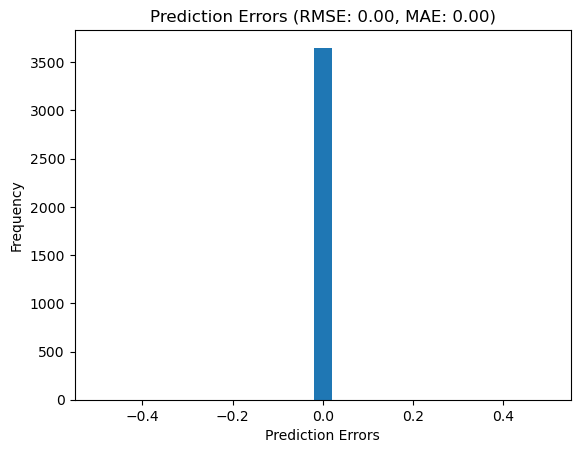

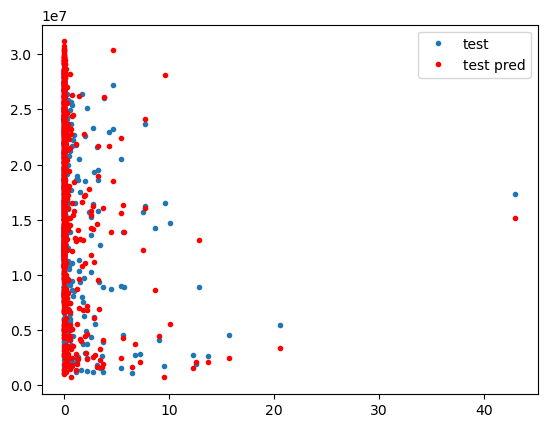

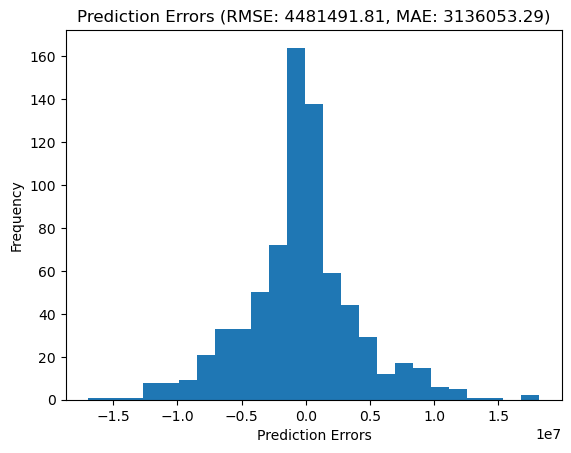

---------------------------------------------------
REGRESSION TREES PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', DecisionTreeRegressor())]),
             param_grid={'model__criterion': ['squared_error'],
                         'model__min_samples_split': [2],
                         'model__splitter': ['best']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__criterion': 'squared_error', 'model__min_samples_split': 2, 'model__splitter': 'best'}

Performance: NMAE (val): -3415756.7763157897 | RMSE train: 0.0 | MAE train: 0.0 | RMSE train: 4481491.812046336 | MAE test: 3136053.287671233
Execution time: 0.6783301830291748s


In [49]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        # ('select', SelectKBest(f_regression)),
        ("model", DecisionTreeRegressor())
    ]
)

param_grid = {
    "model__criterion": ["squared_error"],
    "model__splitter": ["best"],
    "model__min_samples_split": [2],
}
#   'select__k': list(range(1, X_train.shape[1]+1))}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RegTrees_pred"] = model
results["RegTrees_pred"] = score
times["RegTrees_pred"] = total_time

print_results("REGRESSION TREES PREDEFINED PARAMETERS", model, score, total_time)

### 5.2.2. Regression Trees - Selected parameters

Results of the best estimator of Pipeline
NMAE in validation: -2842067.62
RMSE train: 3483153.61	MAE train: 2250097.48
RMSE test: 3695643.80	MAE test: 2493179.59


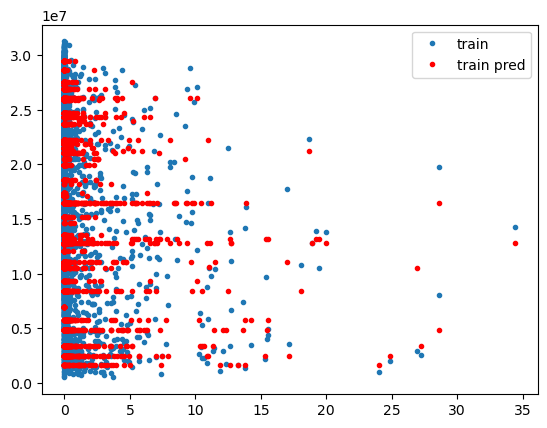

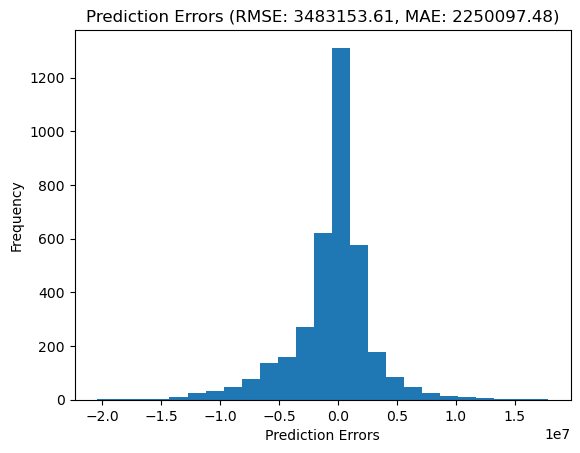

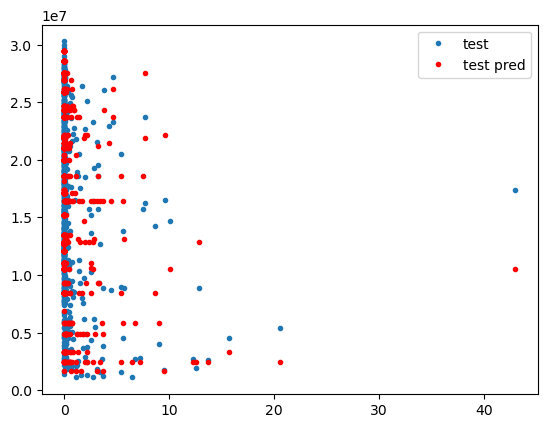

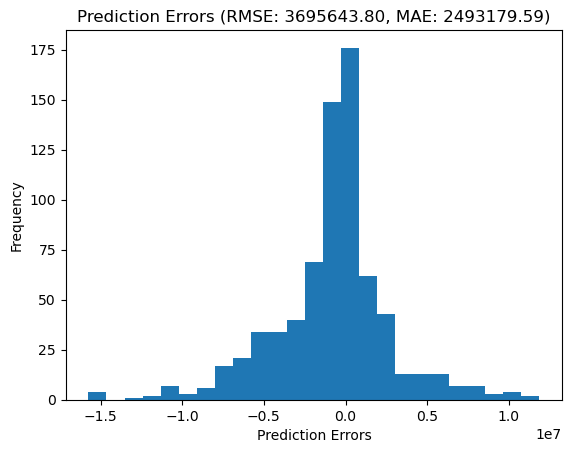

---------------------------------------------------
REGRESSION TREES SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('select',
                                              SelectKBest(score_func=<function f_regression at 0x7effbd8d3f40>)),
                                             ('model',
                                              DecisionTreeRegressor())]),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'model__criterion': ['absolute_error',
                                                             'squared_error'],
                                        'model__max_depth': [5, 10, 15,...
                                                             30, 35, 40, 45, 50,
                                                             55],
                                        'model__max_features': ['sqrt', 'log2',


In [50]:
np.random.seed(10)
budget = 15
n_splits = 5

pipeline = Pipeline(
    [("select", SelectKBest(f_regression)), ("model", DecisionTreeRegressor())]
)

param_grid = {
    "model__criterion": ["absolute_error", "squared_error"],
    "model__splitter": ["best", "random"],
    "model__max_depth": list(range(5, 60, 5)),
    "model__min_samples_split": list(range(5, 200)),
    "model__max_features": ["sqrt", "log2", None],
    "select__k": list(range(1, X_train.shape[1] + 1)),
}

# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RegTrees_select"] = model
results["RegTrees_select"] = score
times["RegTrees_select"] = total_time

print_results("REGRESSION TREES SELECTED PARAMETERS", model, score, total_time)

Note: if we add the selection of parameters, we get a worse result, although the tran and test is way faster.

## 5.3 Linnear regression

In [51]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

### 5.3.1. Linear regression - Predefined parameters

Results of the best estimator of Pipeline
NMAE in validation: -2437056.06
RMSE train: 3254352.60	MAE train: 2321647.06
RMSE test: 3103586.45	MAE test: 2242422.37


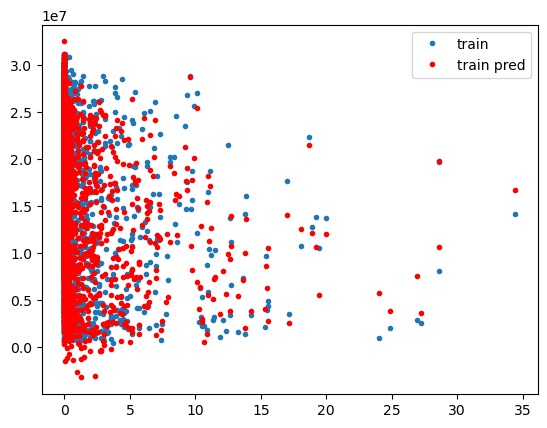

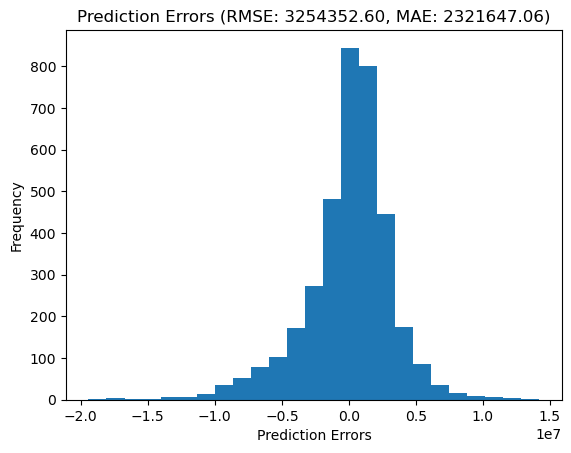

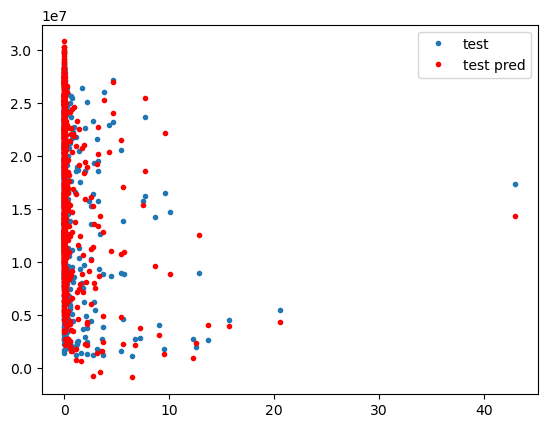

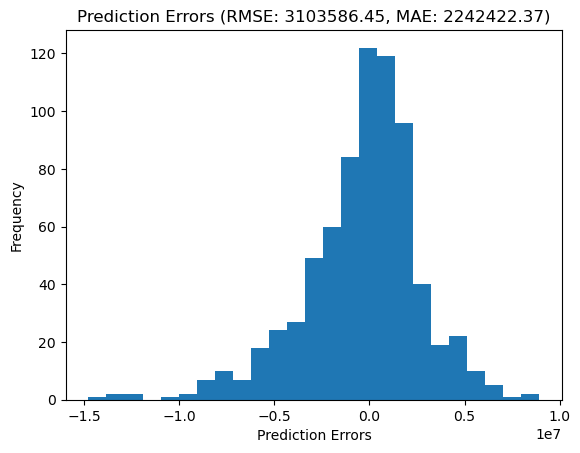

---------------------------------------------------
LINEAR REGRESSION PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', LinearRegression())]),
             param_grid={'model__fit_intercept': [True]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__fit_intercept': True}

Performance: NMAE (val): -2437056.0592060336 | RMSE train: 3254352.6036904673 | MAE train: 2321647.0597032174 | RMSE train: 3103586.448673977 | MAE test: 2242422.367108201
Execution time: 0.07497501373291016s


In [52]:
np.random.seed(10)
n_splits=5

pipeline = Pipeline([
    # ('scaler', StandardScaler()),
    # ('select', SelectKBest(f_regression)),
    ('model', LinearRegression())
])

param_grid = {'model__fit_intercept': [True], }
            #   'select__k': list(range(1, X_train.shape[1]+1))}

model = GridSearchCV(pipeline,
                    param_grid,
                    scoring='neg_mean_absolute_error',
                    cv=TimeSeriesSplit(n_splits)
                    )


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["LinearReg_pred"] = model
results['LinearReg_pred'] = score
times['LinearReg_pred'] = total_time

print_results("LINEAR REGRESSION PREDEFINED PARAMETERS", model, score, total_time)


With the select params, the train test is way slower.

### 5.3.2. Linear regression - Selected parameters

Model: -2723823.0627315757
{'select__k': 41, 'model__alpha': 0.01}
Results of the best estimator of Pipeline
NMAE in validation: -2723823.06
RMSE train: 3767140.00	MAE train: 2747472.88
RMSE test: 3659527.62	MAE test: 2583859.90


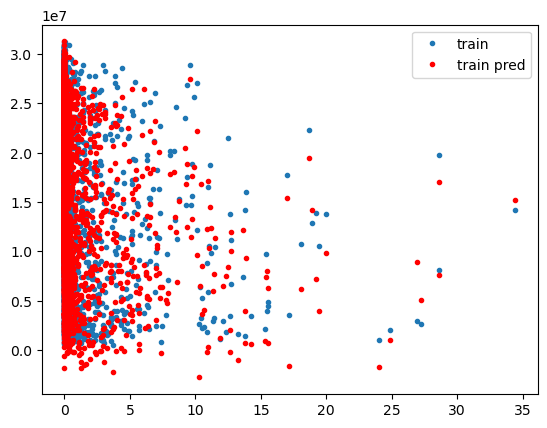

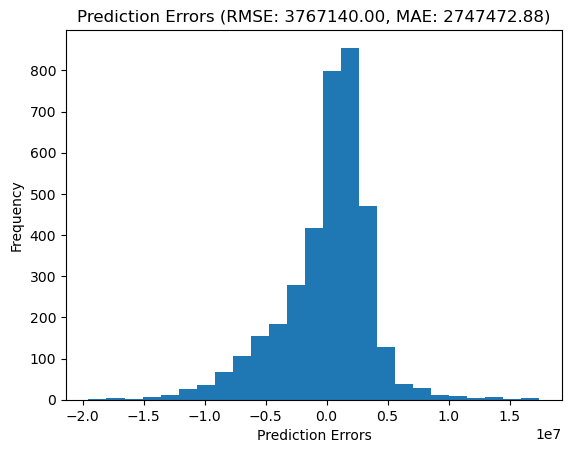

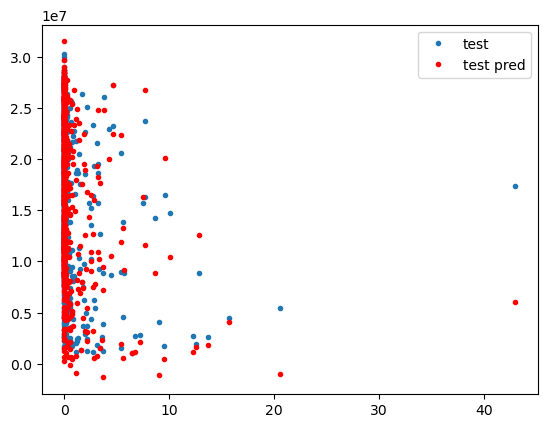

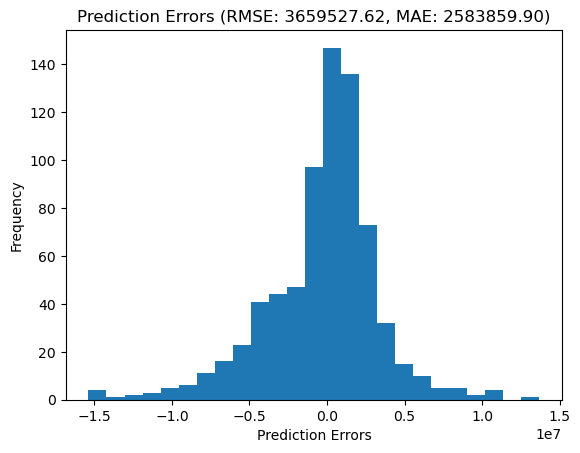

Model: -2409149.2610517377
{'select__k': 75, 'model__alpha': 0.17433288221999882}
Results of the best estimator of Pipeline
NMAE in validation: -2409149.26
RMSE train: 3257805.20	MAE train: 2320591.77
RMSE test: 3095921.14	MAE test: 2234624.56


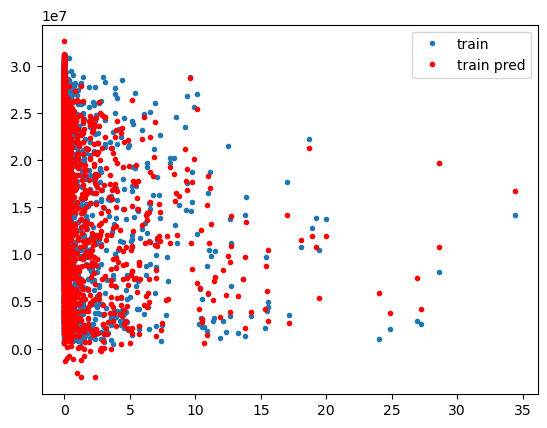

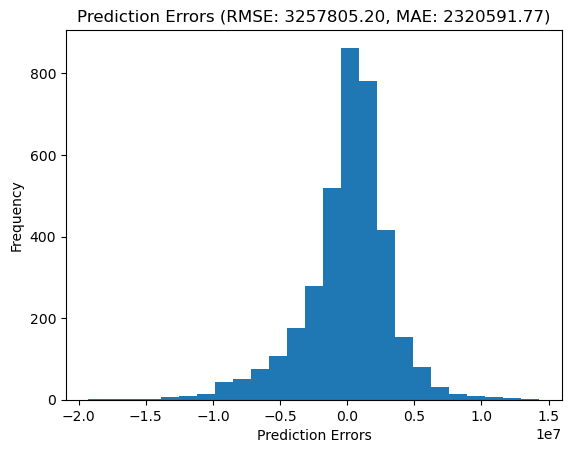

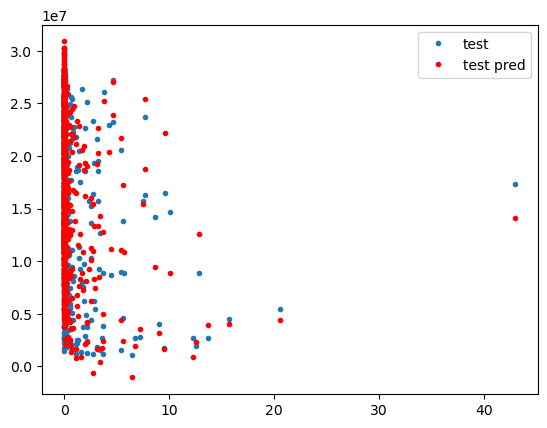

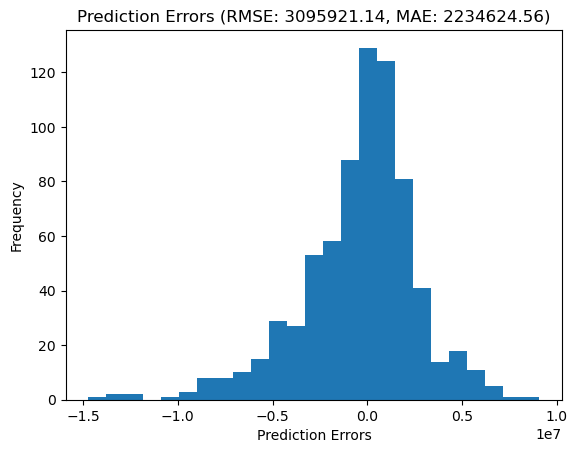

Model: -2826890.3897810644
{'select__k': 30, 'model__l1_ratio': 0.8974358974358974, 'model__alpha': 4.0}
Results of the best estimator of Pipeline
NMAE in validation: -2826890.39
RMSE train: 3758884.17	MAE train: 2827209.45
RMSE test: 3537148.86	MAE test: 2591816.58


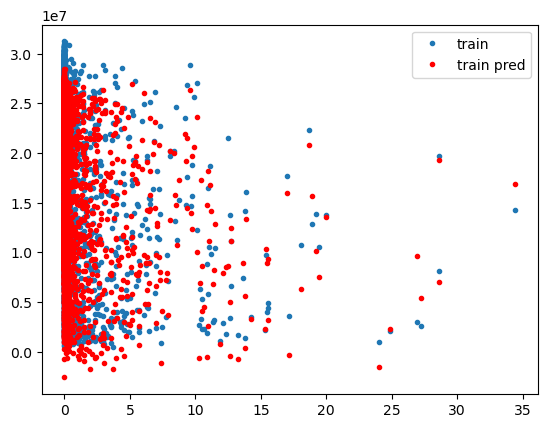

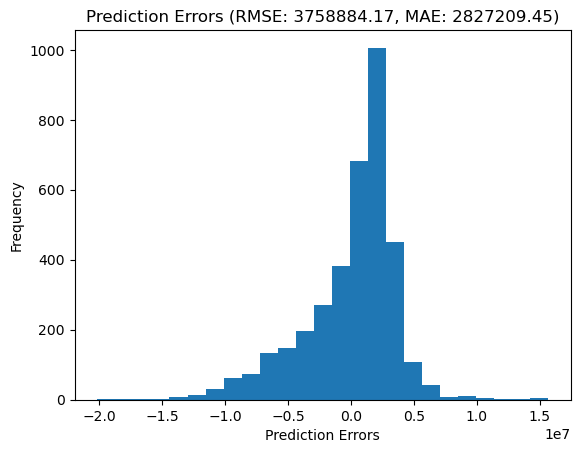

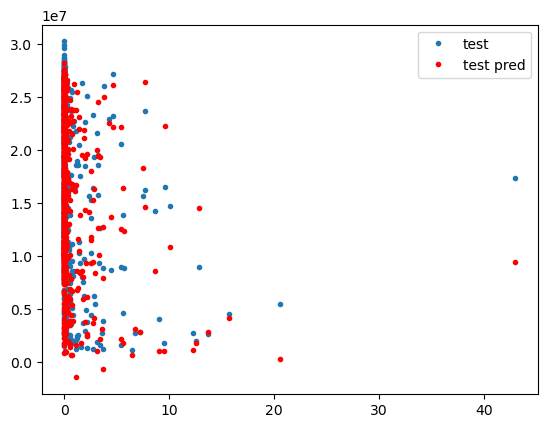

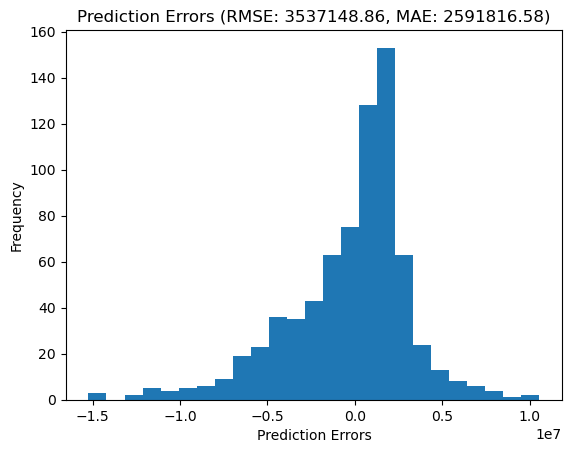

[1.3480560779571533, 1.0837047100067139, 1.1167049407958984]
{'KNN_pred': [-2768275.085526316, 2995411.3954362, 2105354.3342465754, 3669004.351737694, 2589913.2328767125], 'KNN_select': [-2693826.1973684216, 3386909.0476090116, 2410845.287671233, 3394685.600663936, 2420543.4246575343], 'RegTrees_pred': [-3415756.7763157897, 0.0, 0.0, 4481491.812046336, 3136053.287671233], 'RegTrees_select': [-2842067.6151315793, 3483153.6109944335, 2250097.479452055, 3695643.7960636253, 2493179.5890410957], 'LinearReg_pred': [-2437056.0592060336, 3254352.6036904673, 2321647.0597032174, 3103586.448673977, 2242422.367108201], 'LinearReg_select': [-2409149.2610517377, 3257805.1961352024, 2320591.76837326, 3095921.136409502, 2234624.5584775107]}
{'KNN_pred': 0.13675975799560547, 'KNN_select': 2.380321979522705, 'RegTrees_pred': 0.6783301830291748, 'RegTrees_select': 6.445879936218262, 'LinearReg_pred': 0.07497501373291016, 'LinearReg_select': 1.0837047100067139}
Number of selected features: 75
------------

In [53]:
np.random.seed(10)
budget = 15
n_splits = 5

all_scores = []

# ! Pipelines
pipeline_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', Lasso(fit_intercept=True, tol=.5, random_state=10))
])

pipeline_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', Ridge(fit_intercept=True, tol=.5, random_state=10))
])

pipeline_elastic = Pipeline([
    ('scaler', StandardScaler()),
    ('select', SelectKBest(f_regression)),
    ('model', ElasticNet(fit_intercept=True, tol=.5, random_state=10))
])

# ! Parameter grids
param_grid_lasso = {'model__alpha': np.logspace(-2, 1, 30),
              'select__k': list(range(1, X_train.shape[1]+1))}

pram_grid_ridge = {'model__alpha': np.logspace(-2, 1, 30),
              'select__k': list(range(1, X_train.shape[1]+1))}

param_grid_elastic = {'model__alpha': np.logspace(2.0, 3.0, num=4, base=2.0),
                'model__l1_ratio': np.linspace(0, 1, 40),
                'select__k': list(range(1, X_train.shape[1]+1))}

# ! If we want to use random values for the parameters -> unconsistency in the results
regr_lasso = RandomizedSearchCV(pipeline_lasso,
                                param_grid_lasso,
                                scoring='neg_mean_absolute_error',
                                cv=TimeSeriesSplit(),
                                n_iter=budget,
                                )

regr_ridge = RandomizedSearchCV(pipeline_ridge,
                                pram_grid_ridge,
                                scoring='neg_mean_absolute_error',
                                cv=TimeSeriesSplit(),
                                n_iter=budget,
                                )

regr_elastic = RandomizedSearchCV(pipeline_elastic,
                                  param_grid_elastic,
                                  scoring='neg_mean_absolute_error',
                                  cv=TimeSeriesSplit(),
                                  n_iter=budget,
                                  )

model = [regr_lasso, regr_ridge, regr_elastic]


ln_reg_time, scoring = [], []

for i in model:
    start_time = time.time()
    i.fit(X=X_train,y=y_train)
    print(f"Model: {i.best_score_}")
    print(i.best_params_)
    # Now we reevaluate the model on the test set to obtain more accurate results
    scoring.append(i.best_score_) 
    all_scores.append(train_and_test(i.best_estimator_, i.best_score_, X_train, y_train, X_test, y_test))
    ln_reg_time.append(time.time() - start_time)
    
print(ln_reg_time)

# Select the best model (based on the MAE)
max_score = min(all_scores, key=lambda x: abs(x[0]))  # Best model is the one that minimizes the validation NMAE
best_model = model[all_scores.index(max_score)]
total_time = ln_reg_time[all_scores.index(max_score)]

models['LinearReg_select'] = best_model 
results['LinearReg_select'] = max_score
print(results)
times['LinearReg_select'] = total_time
print(times)


# print number of selected features
print(f"Number of selected features: {best_model.best_estimator_.named_steps['select'].get_support().sum()}")

# Print results
print_results("LINEAR REGRESSION SELECTED PARAMETERS", best_model, score, total_time)


To be observed, the selected model, Ridge, does not delete any of the attributes (as expected, as it is one of its flaws), but some of their weights are close to zero, so we can consider that they are not relevant for the model.

On the other hand, the Lasso model and the ElasticNet model, do delete some of the attributes, but the results are worse than the Ridge model, so we will not consider them.

## 5.4. Results

In [54]:
np.random.seed(10)

# ! Obtain best, worst, fastest and slowest model
max_score = max(results.values(), key=lambda x: abs(x[0]))  # We use the scoring (NMAE) as explained above to select the best model
min_score = min(results.values(), key=lambda x: abs(x[0]))
# Obtain the key name of the best and worst model
max_time = max(times.values(), key=lambda x: x)
min_time = min(times.values(), key=lambda x: x)

best_model = list(results.keys())[list(results.values()).index(min_score)]
worst_model = list(results.keys())[list(results.values()).index(max_score)]
fastest_model = list(times.keys())[list(times.values()).index(min_time)]
slowest_model = list(times.keys())[list(times.values()).index(max_time)]

print(f"Best model: {best_model} with score (-NMAE) {abs(min_score[0])} and time {list(times.values())[list(results.values()).index(min_score)]}s")
print(f"Worst model: {worst_model} with score (-NMAE) {abs(max_score[0])} and time {list(times.values())[list(results.values()).index(max_score)]}s")
print(f"Fastest model: {fastest_model} with score (-NMAE) {abs(results[fastest_model][0])} and time {min_time}s")
print(f"Slowest model: {slowest_model} with score(-NMAE) {abs(results[slowest_model][0])} and time {max_time}s")


# ! Average (test MAE) score of the models
avg_score = 0
avg_time = 0

for key, value in results.items():
    avg_score += results[key][0]
    avg_time += times[key]

print(f"\nAverage models score: {abs(avg_score/len(results))}")
print(f"Average models time: {avg_time/len(times)}\n")


# ! Differences
print("The score difference between the best and worst model is: ", abs(max_score[0] - min_score)[0])  # Scoring evaluation -NMAE
print("The score difference between the best and fastest model is: ", abs(min_score[0] - abs(results[fastest_model][0])))  # Scoring evaluation -NMAE
print("The time difference between the best and fastest model model is: ", abs(list(times.values())[list(results.values()).index(min_score)] - min_time))
print("The time difference between the fastest and slowest model is: ", abs(max_time - min_time))

Best model: LinearReg_select with score (-NMAE) 2409149.2610517377 and time 1.0837047100067139s
Worst model: RegTrees_pred with score (-NMAE) 3415756.7763157897 and time 0.6783301830291748s
Fastest model: LinearReg_pred with score (-NMAE) 2437056.0592060336 and time 0.07497501373291016s
Slowest model: RegTrees_select with score(-NMAE) 2842067.6151315793 and time 6.445879936218262s

Average models score: 2761021.832433313
Average models time: 1.7999952634175618

The score difference between the best and worst model is:  1006607.515264052
The score difference between the best and fastest model is:  4846205.320257772
The time difference between the best and fastest model model is:  1.0087296962738037
The time difference between the fastest and slowest model is:  6.370904922485352


KNN_pred: 2768275.085526316
KNN_select: 2693826.1973684216
RegTrees_pred: 3415756.7763157897
RegTrees_select: 2842067.6151315793
LinearReg_pred: 2437056.0592060336
LinearReg_select: 2409149.2610517377


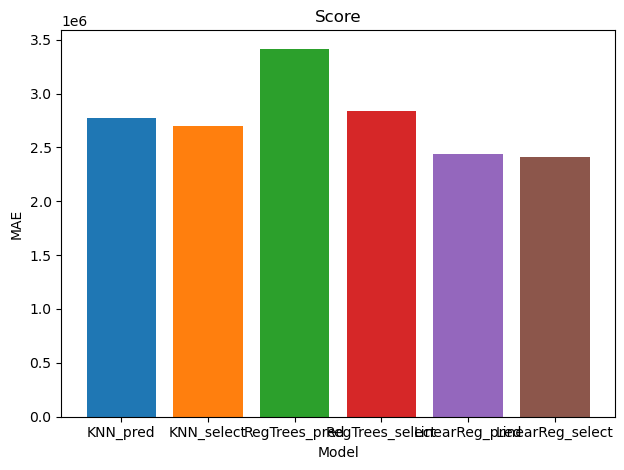

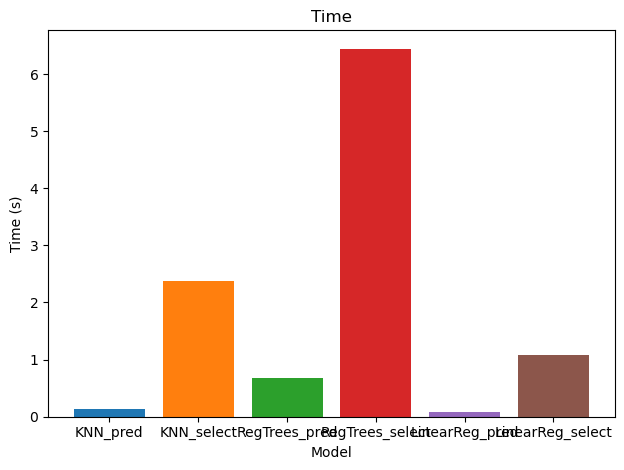

In [55]:
# ! Plot the score
for key, value in results.items():
    plt.bar(key, abs(value[0]))
    print(f"{key}: {abs(value[0])}")
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score.png")
plt.show()

# ! Plot the time
for key, value in times.items():
    plt.bar(key, value)
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

## 5.5. Conclusions: 

After computig the models we can see that the best model in terms of MAE is the LinearReg_selected, but the best timing model is LinearReg_pred.

***Obtener algunas conclusiones, tales como: ¿cuál es el mejor método? ¿Cuál de los métodos 
básicos de aprendizaje automático es más rápido? ¿Los resultados son mejores que los 
regresores triviales/naive/baseline? ¿El ajuste de hiperparámetros mejora con respecto a los 
valores por omisión? ¿Hay algún equilibrio entre tiempo de ejecución y mejora de 
resultados? Etc***



---
# 6. Reducing Dimensionality TODO
>¿Es posible reducir la dimensionalidad del problema?

Yes, it is possible to reduce the problem dimensionality, and as stated throughout the EDA, there are a lot of attributes that are highly correlated, so we can reduce the dimensionality of the problem by removing some of the attributes. Thus, it is recommended to use a PCA to reduce the dimensionality of the problem.

---
# 7. Advanced methods

## 7.1. Support Vector Machines (SVMs)

** REVISAR Y MODIFICAR COMO LO HIZO EL PROFESOR **

In [56]:
from sklearn.svm import SVR

### 7.1.1. SVMs - Predefined parameters

Results of the best estimator of Pipeline
NMAE in validation: -6953359.13
RMSE train: 8058570.03	MAE train: 6899205.34
RMSE test: 7478517.18	MAE test: 6281642.85


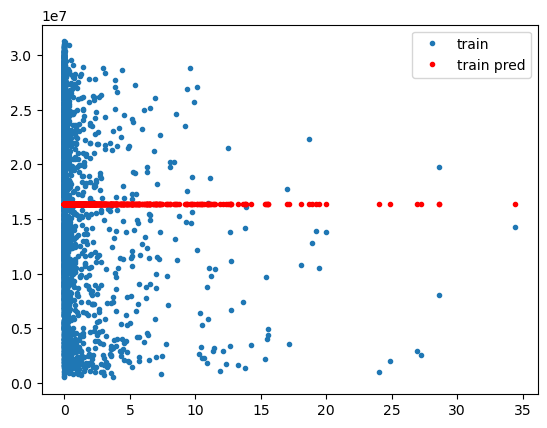

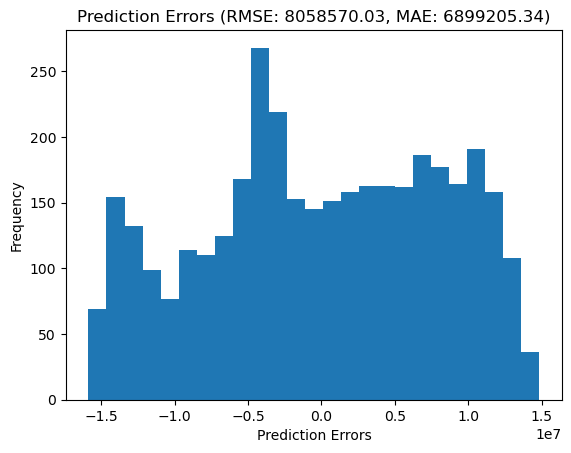

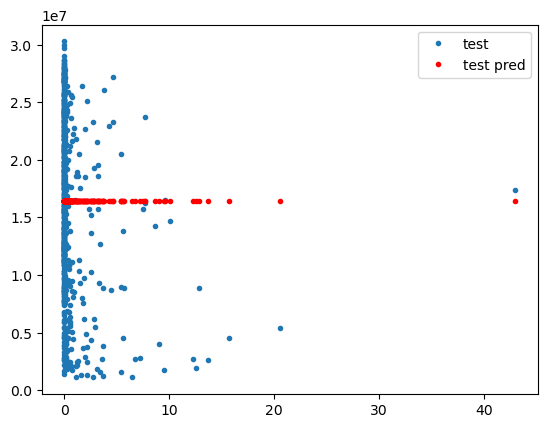

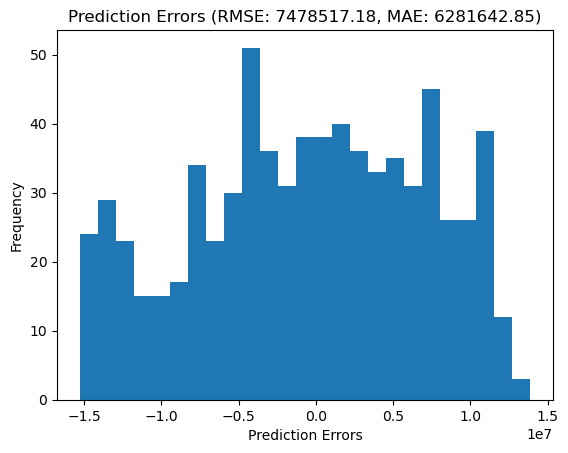

---------------------------------------------------
SVM PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', SVR())]),
             param_grid={'model__C': [1], 'model__degree': [3],
                         'model__epsilon': [0.1], 'model__gamma': ['scale'],
                         'model__kernel': ['rbf']},
             scoring='neg_mean_absolute_error')

Parameters: {'model__C': 1, 'model__degree': 3, 'model__epsilon': 0.1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}

Performance: NMAE (val): -6953359.13401988 | RMSE train: 8058570.025309125 | MAE train: 6899205.344762247 | RMSE train: 7478517.1845604805 | MAE test: 6281642.848032993
Execution time: 2.0801663398742676s


In [57]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        # ('scaler', StandardScaler()),
        # ('select', SelectKBest(f_regression)),
        ("model", SVR())
    ]
)

param_grid = {
    "model__kernel": ["rbf"],
    "model__degree": [3],
    "model__C": [1],
    "model__gamma": ["scale"],
    "model__epsilon": [0.1],
#   'select__k': list(range(1, X_train.shape[1]+1)),
}

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_pred"] = model
results["SVM_pred"] = score
times["SVM_pred"] = total_time

print_results("SVM PREDEFINED PARAMETERS", model, score, total_time)

### 7.1.2. SVMs - Selected parameters

Results of the best estimator of Pipeline
NMAE in validation: -2486447.02
RMSE train: 3499884.83	MAE train: 2450402.31
RMSE test: 3350964.25	MAE test: 2367961.76


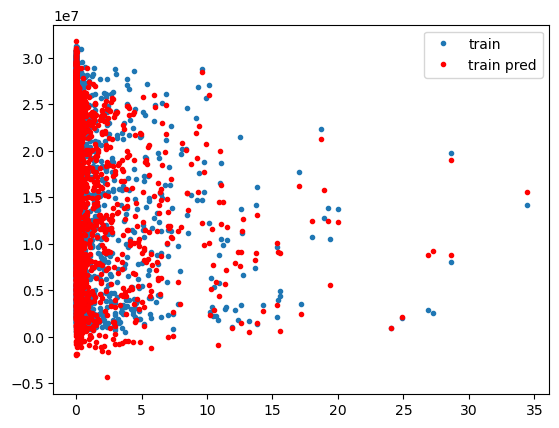

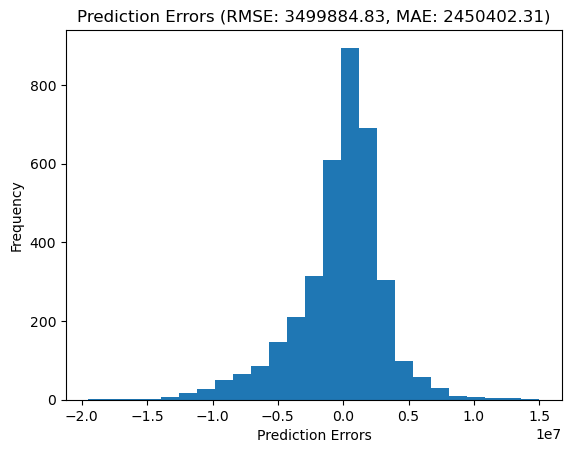

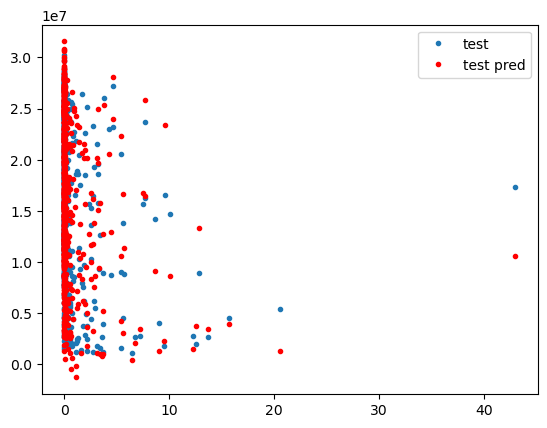

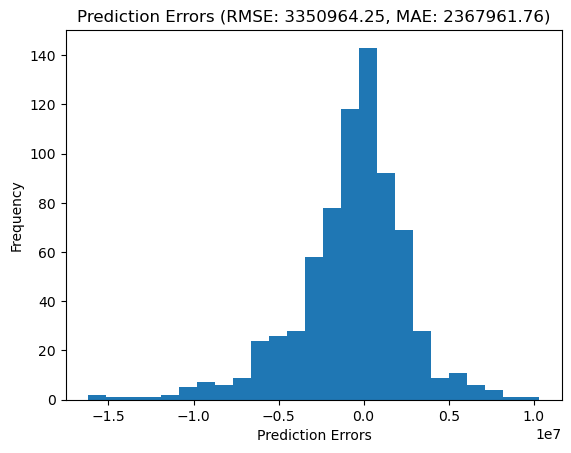

---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model', SVR())]), n_jobs=-1,
                   param_distributions={'model__C': [0.1, 1, 10, 100, 1000],
                                        'model__gamma': ['scale', 'auto', 0.1,
                                                         1, 10, 100, 1000],
                                        'model__kernel': ['linear', 'poly',
                                                          'rbf', 'sigmoid']},
                   scoring='neg_mean_absolute_error')

Parameters: {'model__kernel': 'linear', 'model__gamma': 1000, 'model__C': 100}

Performance: NMAE (val): -2486447.0170368617 | RMSE train: 3499884.8313968377 | MAE train: 2450402.312955736 | RMSE train: 3350964.246768026 | MAE test: 2367961.763977598
Execution time: 9.090594053268433s


In [58]:
np.random.seed(10)
budget = 10
n_splits = 5

pipeline = Pipeline(
    [
        # ('scaler', StandardScaler()),  # We scale the data to avoid overfitting - Recommended for SVMs
        # ('select', SelectKBest(f_regression)),
        ("model", SVR()) # Support Vector Regression (SVM for regression, SVC for classification)
    ]
)

param_grid = {
    "model__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model__C": [0.1, 1, 10, 100, 1000],
    "model__gamma": ["scale", "auto", 0.1, 1, 10, 100, 1000],
#   'select__k': list(range(1, X_train.shape[1]+1))
}

# param_grid = {
#     "model__kernel": ["rbf"],
#     "model__degree": [3],
#     "model__C": [1],
#     "model__gamma": ["scale"],
#     "model__epsilon": [0.1],
# #   'select__k': list(range(1, X_train.shape[1]+1)),
# }

# Note: gamma is 1000 in the border, -> extend the range


# We use TimeSeriesSplit to split the data in folds without losing the temporal order
model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["SVM_select"] = model
results["SVM_select"] = score
times["SVM_select"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

Results of the best estimator of Pipeline
NMAE in validation: -2380065.52
RMSE train: 2336765.92	MAE train: 1667045.08
RMSE test: 3123697.11	MAE test: 2160377.39


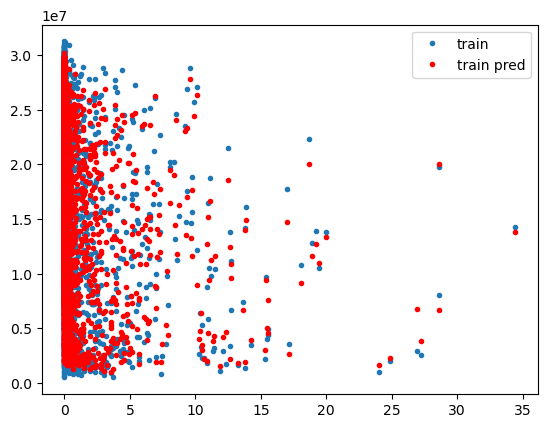

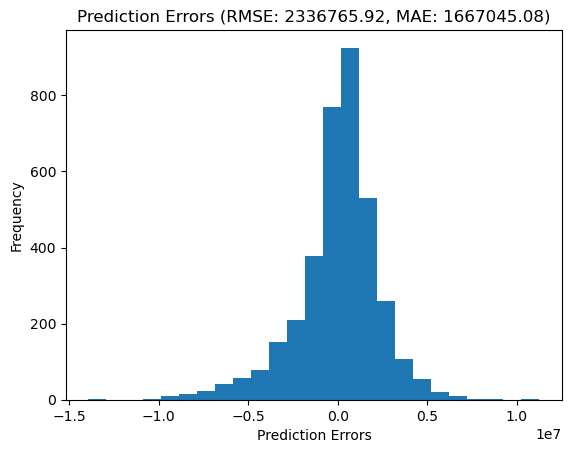

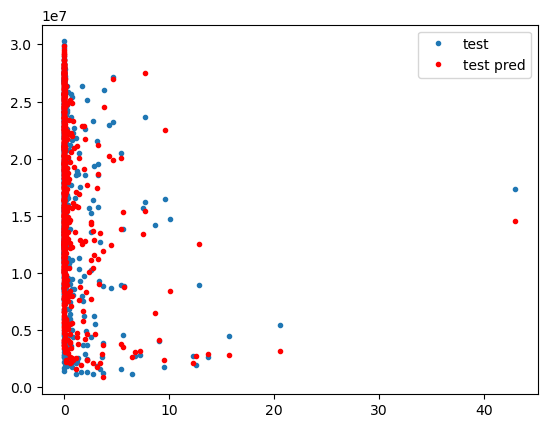

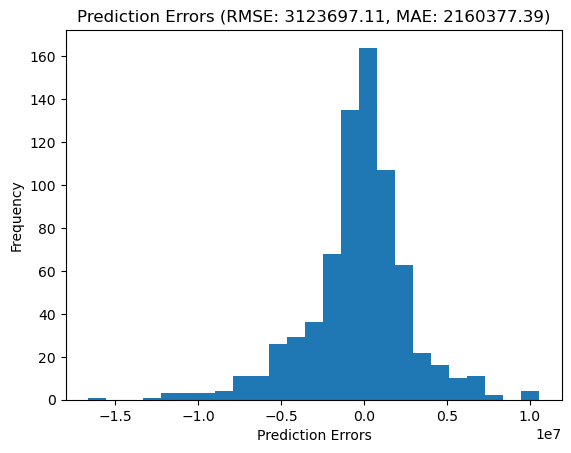

---------------------------------------------------
SVM SELECTED PARAMETERS best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('selector',
                                              SelectKBest(score_func=<function f_regression at 0x7effbd8d3f40>)),
                                             ('model',
                                              GradientBoostingRegressor())]),
                   n_jobs=-1,
                   param_distributions={'model__learning_rate': [0.1, 0.05,
                                                                 0.01],
                                        'model__max_depth': [3, 4, 5],
                                        'model__min_samples_leaf': [1, 2, 4],
                                        'model__min_samples_split': [2, 5, 10],
                          

In [30]:
# Importamos las librerías necesarias
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
import time

np.random.seed(10)
budget = 10
n_splits = 5

pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("selector", SelectKBest(f_regression)),
        ("model", GradientBoostingRegressor()),
    ]
)

param_grid = {
    "selector__k": [5, 10, 20, "all"],
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.1, 0.05, 0.01],
    "model__max_depth": [3, 4, 5],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4],
    "model__subsample": [0.8, 0.9, 1.0],
    "model__random_state": [10],
}

model = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits=n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["GradientBoosting_select"] = model
results["GradientBoosting_select"] = score
times["GradientBoosting_select"] = total_time

print_results("SVM SELECTED PARAMETERS", model, score, total_time)

**Es mucho peor el resultado con escalado y seleccion de parametros y MAS LENTO!!!!**

## 7.2. Random Forests

In [59]:
from sklearn.ensemble import RandomForestRegressor

### 7.2.1. Random Forests - Predefined parameters

Results of the best estimator of Pipeline
NMAE in validation: -2453026.62
RMSE train: 1230647.08	MAE train: 859275.53
RMSE test: 3167880.67	MAE test: 2219648.30


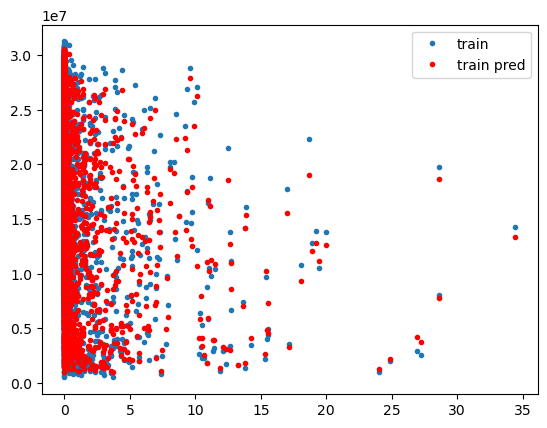

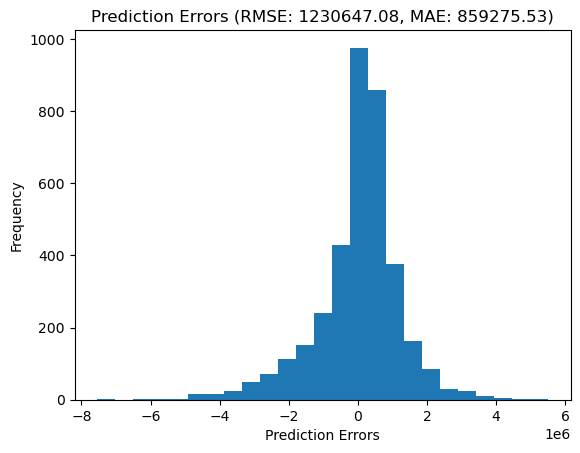

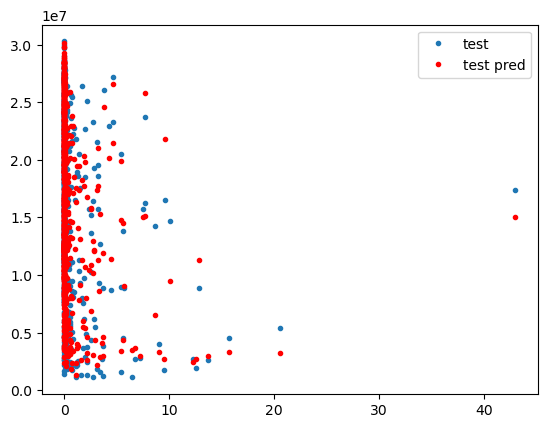

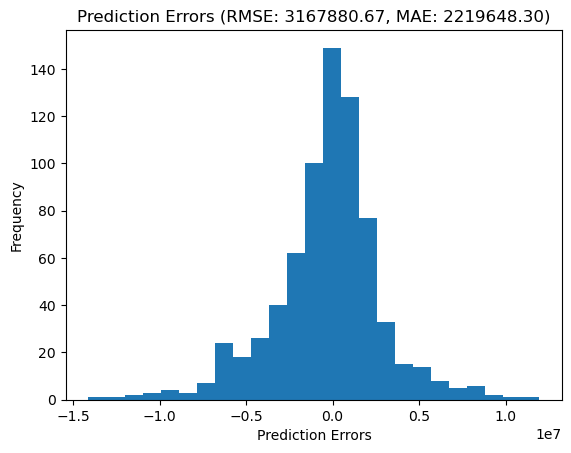

---------------------------------------------------
RANDOM FOREST PREDEFINED PARAMETERS best model is:

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('model', RandomForestRegressor())]),
             param_grid={'model__bootstrap': [True],
                         'model__criterion': ['squared_error'],
                         'model__max_depth': [None],
                         'model__max_features': [None],
                         'model__max_leaf_nodes': [None],
                         'model__min_impurity_decrease': [0.0],
                         'model__min_samples_leaf': [1],
                         'model__min_samples_split': [2],
                         'model__n_estimators': [100],
                         'model__random_state': [10]},
             scoring='neg_mean_absolute_error')

Parameters: {'model__bootstrap': True, 'model__criterion': 'squared_error', 'model__max_depth': None, 'model

In [60]:
np.random.seed(10)
n_splits = 5

pipeline = Pipeline(
    [
        # ('select', SelectKBest(f_regression)),
        ("model", RandomForestRegressor())
    ]
)

param_grid = {
    "model__n_estimators": [100],
    "model__max_features": [None],
    "model__criterion": ["squared_error"],
    "model__max_depth": [None],
    "model__min_samples_split": [2],
    "model__min_samples_leaf": [1],
    "model__max_leaf_nodes": [None],
    "model__min_impurity_decrease": [0.0],
    "model__bootstrap": [True],
    # 'select__k': list(range(1, X_train.shape[1]+1)),
    "model__random_state": [10],
}

# "model__max_depth": [None],
# "model__min_samples_split": [2],
# "model__min_samples_leaf": [1],
# 'model__min_weight_fraction_leaf': [0.0],
# "model__max_features": [1.0], -> con este se da el mejor modelo, mejor que arriba
# "model__max_leaf_nodes": [None],
# "model__min_impurity_decrease": [0.0],
# "model__bootstrap": [True],
# 'model__random_state': [10],
# 'model__ooob_score': [False],
# # "select__k": list(range(1, X_train.shape[1] + 1)),

model = GridSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
)


start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_pred"] = model
results["RandForest_pred"] = score
times["RandForest_pred"] = total_time

print_results(
    "RANDOM FOREST PREDEFINED PARAMETERS", model, score, total_time
)

### 7.2.2. Random Forests - Selected parameters

Results of the best estimator of Pipeline
NMAE in validation: -2376407.75
RMSE train: 1629084.48	MAE train: 1157745.32
RMSE test: 3032944.81	MAE test: 2085348.18


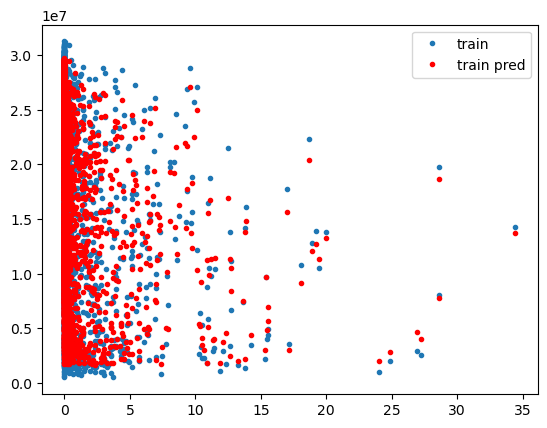

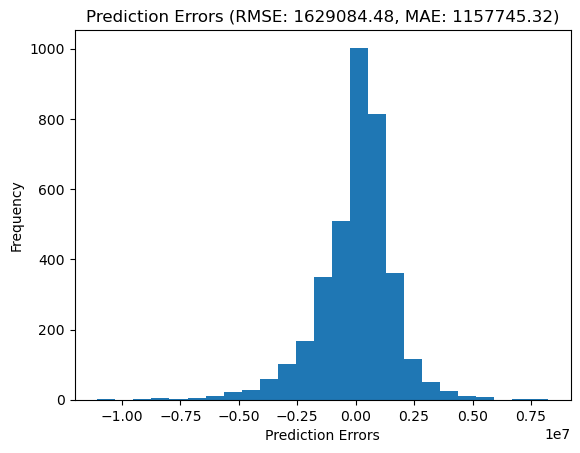

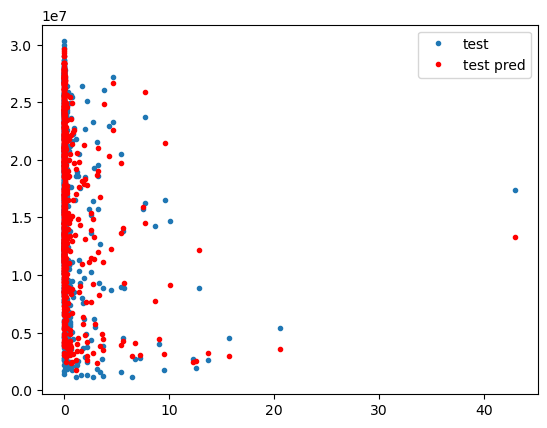

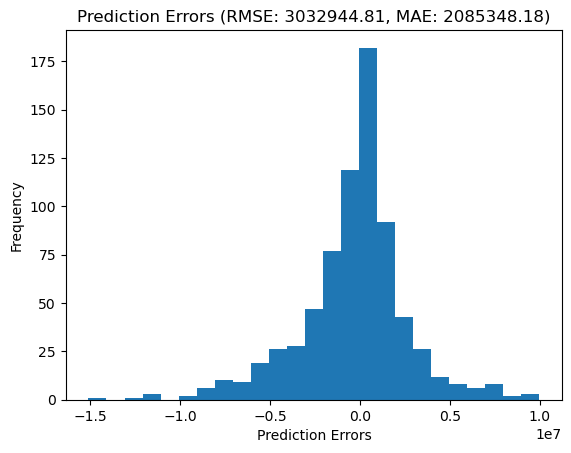

---------------------------------------------------
Random Forest best model is:

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20, 23,
                                                             25, 30, 35, 40],
                                        'model__max_features': ['log2'],
                                        'model__max_leaf_nodes': [None, 10, 100,
                                                                  500],
                                        'model__min_samples_leaf': [1, 2, 4, 6,
                                                                    8],
                                        'model__min_samples_split': [2, 5, 10,
                                      

In [61]:
np.random.seed(10)
budget = 30
n_splits = 5

pipeline = Pipeline(
    [
        # ('select', SelectKBest(f_regression)),
        ("model", RandomForestRegressor())
    ]
)

param_grid = {
    "model__n_estimators": [10, 100, 300, 500, 550, 600, 700, 750, 800, 900, 1000],
    "model__max_depth": [5, 10, 15, 20, 23, 25, 30, 35, 40],
    "model__min_samples_split": [2, 5, 10, 15, 20],
    "model__min_samples_leaf": [1, 2, 4, 6, 8],
    # It is preferred to use log2 as allows a greater number of features to be sampled compared to sqrt while 1.0 picks all features which leads to overfitting and slowness
    # And by testing it several times with different parameters, it was observed that it is the one that gives the best results.
    "model__max_features": ["log2"],
    "model__max_leaf_nodes": [None, 10, 100, 500],
    # "select__k": list(range(1, X_train.shape[1] + 1)),
    "model__random_state": [10],
}

# "model__max_depth": [None],
# "model__min_samples_split": [2],
# "model__min_samples_leaf": [1],
# "model__max_leaf_nodes": [None],
# "model__min_impurity_decrease": [0.0],
# "model__bootstrap": [True],
# "model__n_estimators": list(range(100, 230, 10)),
# "model__max_features": ['sqrt', 'log2', 1.0, 0.7, 0.5, 0.3, 0.1],
# Above 2 are the ones seen in class
# "model__max_depth": [None, 5, 10, 15, 20],
# "model__min_samples_split": [2, 5, 10, 15, 20],
# "model__min_samples_leaf": [1, 2, 4, 6, 8],
# 'select__k': list(range(1, X_train.shape[1]+1)),

model = RandomizedSearchCV(
    pipeline,
    param_grid,
    scoring="neg_mean_absolute_error",
    cv=TimeSeriesSplit(n_splits),
    n_iter=budget,
    n_jobs=-1,
)

start_time = time.time()
model.fit(X=X_train, y=y_train)
end_time = time.time()

total_time = end_time - start_time

score = train_and_test(
    model.best_estimator_, model.best_score_, X_train, y_train, X_test, y_test
)

models["RandForest_select"] = model
results["RandForest_select"] = score
times["RandForest_select"] = total_time

print_results("Random Forest", model, score, total_time)

---
# 8. Best model
We will re-visit all the models and select the best one, which we have stated to be the one with the lowest MAE and the lowest RMSE.



0. Sected model: KNN_pred

Parameters: {'model__metric': 'minkowski', 'model__n_neighbors': 5, 'model__weights': 'uniform'}
Score NMAE in train-validation: -2768275.085526316
Score MAE (train): 2105354.3342465754 | Score RMSE (train): 2995411.3954362
Score MAE (test): 2589913.2328767125 | Score RMSE (test): 3669004.351737694
Time: 0.13675975799560547


1. Sected model: KNN_select

Parameters: {'select__k': 30, 'model__weights': 'uniform', 'model__n_neighbors': 15, 'model__metric': 'manhattan'}
Score NMAE in train-validation: -2693826.1973684216
Score MAE (train): 2410845.287671233 | Score RMSE (train): 3386909.0476090116
Score MAE (test): 2420543.4246575343 | Score RMSE (test): 3394685.600663936
Time: 2.380321979522705


2. Sected model: RegTrees_pred

Parameters: {'model__criterion': 'squared_error', 'model__min_samples_split': 2, 'model__splitter': 'best'}
Score NMAE in train-validation: -3415756.7763157897
Score MAE (train): 0.0 | Score RMSE (train): 0.0
Score MAE (test): 3136053.

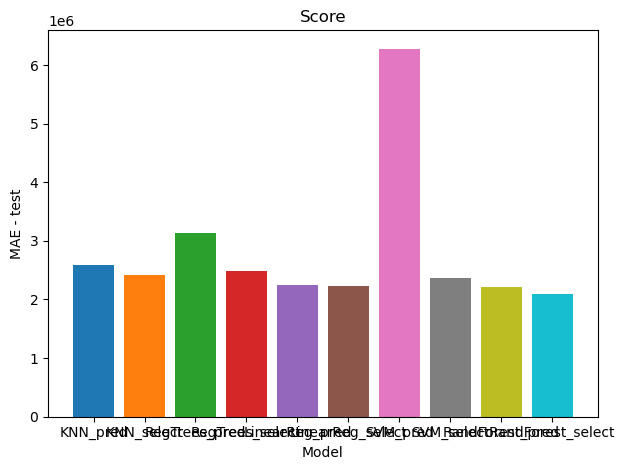

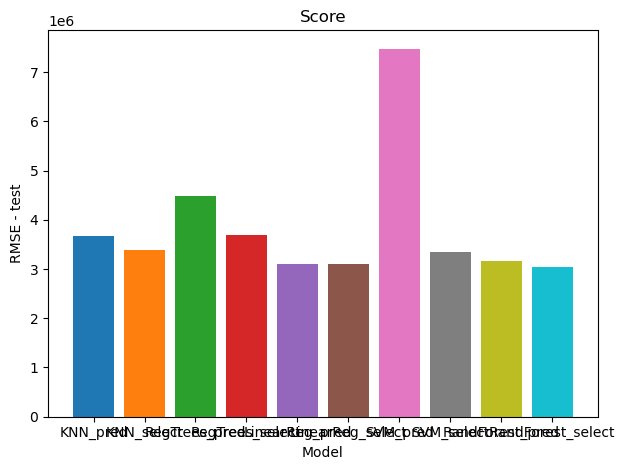

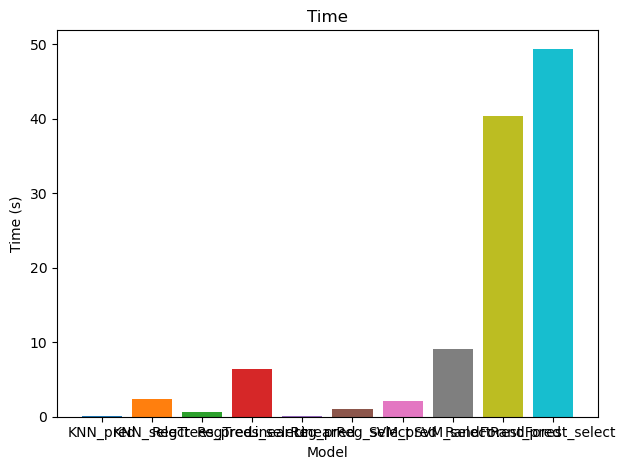

In [62]:
# ! Print the models best parameters
i = 0
for key, value in models.items():
    print(f"\n\n{i}. Sected model: {key}\n")
    print(f"Parameters: {value.best_params_}")
    print(f"Score NMAE in train-validation: {results[key][0]}")
    print(f"Score MAE (train): {results[key][2]} | Score RMSE (train): {results[key][1]}")
    print(f"Score MAE (test): {results[key][4]} | Score RMSE (test): {results[key][3]}")
    print(f"Time: {times[key]}")
    i+=1

# ! Plot the test score (MAE)
for key, value in results.items():
    plt.bar(key, abs(value[4]))
    # print(f"{key}: {abs(value[3])}")
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("MAE - test")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score_mae.png")
plt.show()

# ! Plot the test score (RMSE)
for key, value in results.items():
    plt.bar(key, abs(value[3]))
    # print(f"{key}: {abs(value[2])}")
plt.title("Score")
plt.xlabel("Model")
plt.ylabel("RMSE - test")
plt.tight_layout()

# Exporting image as png to ../data/img folder
plt.savefig("../data/img/basic_methods_score_rmse.png")
plt.show()

# ! Plot the time
for key, value in times.items():
    plt.bar(key, value)
plt.title("Time")
plt.xlabel("Model")
plt.ylabel("Time (s)")
plt.tight_layout()

# Exporting image as png to ../data/img folder - easier to visualize the annotations, better resolution
plt.savefig("../data/img/basic_methods_time.png")
plt.show()

## 8.2. Exportación del modelo seleccionado

In [ ]:
import pickle
# ! TODO: Importante, hay que volverlo a entrenar creo
# Export final selected model (RandForest_select) -> 10th position
# Select the 9th position in the dictionary
selected_model = models["RandForest_select"]
print(f"\nSelected model: {model}")

# Export model as pickle file in ../data/model folder
with open("../data/model/modelo_final.pkl", "wb") as file:
    pickle.dump(selected_model, file)

# ! Compare the model exported with the one loaded - check if it is the same
# Load model from pickle file
with open("../data/model/modelo_final.pkl", "rb") as file:
    loaded_model = pickle.load(file)

print(f"\nSaved model: {loaded_model}, {type(loaded_model)}, {loaded_model.best_params_}")
    
if selected_model.best_params_ == loaded_model.best_params_:
    print("\n\nThe models are the same")
else:
    print("\n\nERROR: The models are different")


Selected model: RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('model',
                                              RandomForestRegressor())]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20, 23,
                                                             25, 30, 35, 40],
                                        'model__max_features': ['log2'],
                                        'model__max_leaf_nodes': [None, 10, 100,
                                                                  500],
                                        'model__min_samples_leaf': [1, 2, 4, 6,
                                                                    8],
                                        'model__min_samples_split': [2, 5, 10,
                                                                     15, 20],
                         

---
# 9. Conclusiones

---
# X. Output the Jupyter Notebook as an HTML file

In [ ]:
import os

# Export the notebook to HTML
os.system("jupyter nbconvert --to html model.ipynb --output ../data/html/model.html")
print("Notebook exported to HTML")

[NbConvertApp] Converting notebook model.ipynb to html


Notebook exported to HTML


[NbConvertApp] Writing 2572892 bytes to ../data/html/model.html
